In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import os, glob
from scipy.stats import pearsonr
os.chdir("/data/dhence/a/pborse2/inputdata/data.eol.ucar.edu/pub/download/extra/katz_data/stage4/daily_data")

# Mosquito data

In [2]:
mosshp = gpd.read_file('/data/dhence/a/pborse2/inputdata/Mosquito data/sampling_locations/CU_2013_DDB_ditch_visited.shp')

In [3]:
mossurvey = pd.read_csv('/data/dhence/a/pborse2/inputdata/Mosquito data/DDB_ditch_survey_2013_Champaign-Urbana.xlsx - raw.csv')

In [5]:
mcol = list(mossurvey.columns)

In [6]:
mosfile = mossurvey[mcol[:15]+mcol[26:27]+mcol[34:36]+mcol[48:50]+mcol[62:64]+mcol[72:73]]

In [7]:
mosfile['larpupsum']=mosfile[mosfile.columns[-8:]].sum(axis=1)

/tmp/ipykernel_43791/109621437.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mosfile['larpupsum']=mosfile[mosfile.columns[-8:]].sum(axis=1)


In [8]:
mosfile

Sampling_Period  Coll_date  Site_ID Location  Veg_type Hab_Type  \
0                  1   5-Jun-13      335        A         1    Basin   
1                  1   4-Jun-13      338        A         1    Basin   
2                  1   4-Jun-13      345        A         0    Basin   
3                  1   5-Jun-13      346        A         1    Basin   
4                  1   5-Jun-13      356        A         1    Ditch   
..               ...        ...      ...      ...       ...      ...   
227                6  12-Aug-13      601        C         1    Basin   
228                6  13-Aug-13      602        B         1    Basin   
229                6  12-Aug-13      603        A         0    Basin   
230                6  14-Aug-13      604        A         0    Basin   
231                6  14-Aug-13      606        A         0    Ditch   

    Habitat_Dry  Dips Recent_mow  Mow_class  ...  Pupa_Ae_per20dips  L1_Cx_sp  \
0             N    20          N        2.0  ...                1.0       0.0   
1             N    20          N        2.0  ...                0.0       1.0   
2             N     5          Y        1.0  ...                0.0       0.0   
3             N    20          N        2.0  ...                0.0       0.0   
4             N    20          N        2.0  ...                0.0       0.0   
..          ...   ...        ...        ...  ...                ...       ...   
227           Y     0          N        NaN  ...                NaN       NaN   
228           Y     0          N        NaN  ...                NaN       NaN   
229           Y     0          N        NaN  ...                NaN       NaN   
230           Y     0          N        NaN  ...                NaN       NaN   
231           N    20          Y        1.0  ...                0.0       9.0   

     L2_Cx_pip  L2_Cx_res  L3_Cx_pip  L3_Cx_res  L4_Cx_pip  L4_Cx_res  \
0          0.0        0.0        0.0        0.0        0.0        0.0   
1         13.0        1.0       29.0        2.0        2.0        0.0   
2          0.0        0.0        0.0        0.0        0.0        0.0   
3          0.0        0.0        0.0        0.0        0.0        0.0   
4          0.0        0.0        0.0        0.0        0.0        0.0   
..         ...        ...        ...        ...        ...        ...   
227        NaN        NaN        NaN        NaN        NaN        NaN   
228        NaN        NaN        NaN        NaN        NaN        NaN   
229        NaN        NaN        NaN        NaN        NaN        NaN   
230        NaN        NaN        NaN        NaN        NaN        NaN   
231       39.0        0.0       28.0        0.0       17.0        0.0   

     Pupae_Cxsp  larpupsum  
0           0.0        0.0  
1          10.0       58.0  
2           0.0        0.0  
3           0.0        0.0  
4           0.0        0.0  
..          ...        ...  
227         NaN        0.0  
228         NaN        0.0  
229         NaN        0.0  
230         NaN        0.0  
231         2.0       95.0  

[232 rows x 24 columns]

In [3]:
import cartopy.crs as ccrs
crs = ccrs.NorthPolarStereo()
crs_proj4 = crs.proj4_init
mos1 = mosshp.to_crs(crs_proj4)
mos1 = mos1.rotate(105, origin=(0,0))
mosshp['geometry'] = mos1

AttributeError: partially initialized module 'fiona' has no attribute '_loading' (most likely due to a circular import)

# Streamflow data

In [8]:
#streamgage locations
latlon = pd.DataFrame({'longitude': [-88.1520, -88.3070, -88.21944, -88.22644], 'latitude': [40.1292, 40.0976, 40.11113, 40.11117]})
geom = gpd.points_from_xy(latlon.longitude, latlon.latitude, crs="EPSG:4326")
gage = gpd.GeoDataFrame(latlon, geometry=geom)
gage1 = gage.to_crs(crs_proj4)
gage1 = gage1.rotate(105, origin=(0,0))
gage['geometry'] = gage1

In [9]:
gage['longitude'] = gage['geometry'].x
gage['latitude'] = gage['geometry'].y

<AxesSubplot:>

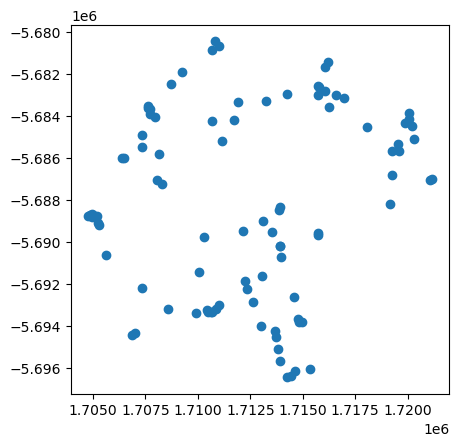

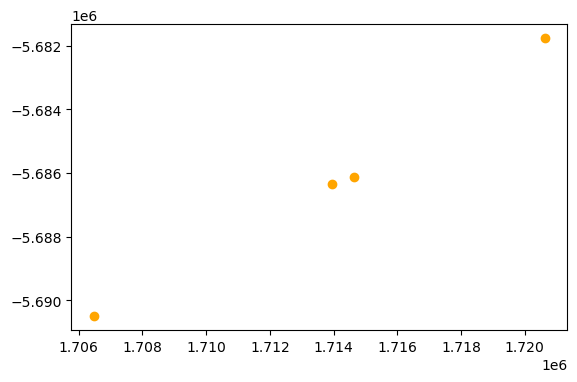

In [10]:
mosshp.plot()
gage.plot(color = 'orange')

In [8]:
flist = [f for f in glob.glob('*.nc')] ## Yearly precipitation files
flist.sort()

In [9]:
flist

['yr2002.nc',
 'yr2003.nc',
 'yr2004.nc',
 'yr2005.nc',
 'yr2006.nc',
 'yr2007.nc',
 'yr2008.nc',
 'yr2009.nc',
 'yr2010.nc',
 'yr2011.nc',
 'yr2012.nc',
 'yr2013.nc',
 'yr2014.nc',
 'yr2015.nc',
 'yr2016.nc',
 'yr2017.nc',
 'yr2018.nc',
 'yr2019.nc']

In [4]:
def masked(ncfile): #Take the nc file as input
    # This csv file is used to select contiguous US
    state_df = pd.read_csv('/data/dhence/a/pborse2/inputdata/state_lookup.csv')
    state_df = state_df.loc[state_df['ContiguousUS'] == 1]
    # Shpfile for counties in US
    counties = gpd.read_file('/data/dhence/a/pborse2/inputdata/USA_Counties/USA_Counties.shp')
    counties = counties.loc[counties['STATE_NAME'].isin(state_df['Name'])]
    champ = gpd.read_file('/data/dhence/a/pborse2/inputdata/Champaign Zoning/Zoning.shp')
    
    # Reproject the counties gdf to polar stereographic projection
    # It is the most appropriate to match the netcdf's projection to display the contiguous US
    import cartopy.crs as ccrs
    crs = ccrs.NorthPolarStereo()
    crs_proj4 = crs.proj4_init
    counties1 = counties.to_crs(crs_proj4)
    counties1 = counties1.rotate(105, origin=(0,0))
    counties['geometry'] = counties1
    
    ch1 = champ.to_crs(crs_proj4) ##Reprojecting shapefile for champaign city
    ch1 = ch1.rotate(105, origin=(0,0))
    champ['geometry']=ch1
    
    f = xr.open_dataarray(ncfile) ####INPUT ALERT####
    lonm = [((x-401)*4762.5)+170000 for x in f.x]
    latm = [((y-1601)*4762.5)-375237.5 for y in f.y] ##These formulae come from https://www.caee.utexas.edu/prof/maidment/gishyd97/library/nexrad/Sect3.pdf
    ###Value of latm is adjusted according to shapefile by subtracting 375237.5 in order to mask out correct region
#     lonm = [((x-401)*4762.5) for x in f.x]
#     latm = [((y-1601)*4762.5) for y in f.y]

    f['x']=lonm
    f['y']=latm
    
    #Assign a CRS to nc file as it's CRS is unknown in documentation but from website, it is polar stereographic 
    f = f.rio.write_crs(crs_proj4 , inplace=True)
    
    ## Mask out region of interest
    import salem
    f.attrs['pyproj_srs'] = crs_proj4
    ds = f.salem.roi(shape=counties[(counties['STATE_NAME']=='Illinois')&(counties['NAME']=='Champaign')])
    return ds,champ, counties, f

In [5]:
state_df = pd.read_csv('/data/dhence/a/pborse2/inputdata/state_lookup.csv')
state_df = state_df.loc[state_df['ContiguousUS'] == 1]
# Shpfile for counties in US
counties = gpd.read_file('/data/dhence/a/pborse2/inputdata/USA_Counties/USA_Counties.shp')
counties = counties.loc[counties['STATE_NAME'].isin(state_df['Name'])]

In [10]:
masked(flist[2])[2]

AttributeError: partially initialized module 'fiona' has no attribute '_loading' (most likely due to a circular import)

In [1]:
from ipynb.fs.defs.Mosquitodataset1_Yearlybatchdata import yearlyfile, batch1, batchdf1

In [2]:
mos = yearlyfile("Mosquito yearly.xlsx",'U-C')[0]
mosyr = yearlyfile("Mosquito yearly.xlsx",'U-C')[1]

In [3]:
batch = batch1(mosyr,mos)
batchdf = batchdf1(mos)

In [6]:
os.chdir("/data/dhence/a/pborse2/inputdata/data.eol.ucar.edu/pub/download/extra/katz_data/stage4/daily_data")
f = [masked(i)[-1] for i in flist]

AttributeError: partially initialized module 'fiona' has no attribute '_loading' (most likely due to a circular import)

In [20]:
f[1]

<xarray.DataArray 'tp' (time: 364)>
array([36.4,  1.4,  1.5, ...,  0. ,  9.1,  0. ], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2002-12-31T12:00:00 ... 2003-12-30T12:...
    step         timedelta64[ns] ...
    surface      float64 ...
    latitude     float64 ...
    longitude    float64 ...
    valid_time   (time) datetime64[ns] ...
    x            float64 1.719e+06
    y            float64 -5.682e+06
    spatial_ref  int64 0
Attributes:
    GRIB_paramId:                    228228
    GRIB_numberOfPoints:             987601
    GRIB_typeOfLevel:                surface
    GRIB_stepUnits:                  1
    GRIB_stepType:                   accum
    GRIB_gridType:                   polar_stereographic
    GRIB_NV:                         0
    GRIB_cfName:                     unknown
    GRIB_cfVarName:                  tp
    GRIB_gridDefinitionDescription:  Polar Stereographic Projection Grid
    GRIB_missingValue:               9999
    GRIB_name:                       Total Precipitation
    GRIB_shortName:                  tp
    GRIB_units:                      kg m**-2
    long_name:                       Total Precipitation
    units:                           kg m**-2
    standard_name:                   unknown
    pyproj_srs:                      +ellps=WGS84 +proj=stere +lat_0=90 +lon_...

In [3]:
os.chdir("/data/dhence/a/pborse2/inputdata/data.eol.ucar.edu/pub/download/extra/katz_data/stage4/daily_data/champ_dailyppt")
# ds = masked(flist[-7])[0]
# champ = masked(flist[-7])[1]

In [8]:
flist1 = [f for f in glob.glob('*.nc')]
flist1.sort()

In [4]:
flist1

['daily_data-champ-2002.nc',
 'daily_data-champ-2003.nc',
 'daily_data-champ-2004.nc',
 'daily_data-champ-2005.nc',
 'daily_data-champ-2006.nc',
 'daily_data-champ-2007.nc',
 'daily_data-champ-2008.nc',
 'daily_data-champ-2009.nc',
 'daily_data-champ-2010.nc',
 'daily_data-champ-2011.nc',
 'daily_data-champ-2012.nc',
 'daily_data-champ-2013.nc',
 'daily_data-champ-2014.nc',
 'daily_data-champ-2015.nc',
 'daily_data-champ-2016.nc',
 'daily_data-champ-2017.nc',
 'daily_data-champ-2018.nc',
 'daily_data-champ-2019.nc']

In [5]:
ncchamp1 = [xr.open_dataset(i).sel(time = slice(i[-7:-3]+'-01-01',i[-7:-3]+'-12-31')) for i in flist1]

In [5]:
da = xr.open_mfdataset(flist1).chunk({'time':-1}) ##For EoF analysis 

In [16]:
##To check how many files have all input data missing
solvlist = []
from eofs.xarray import Eof
for i in ncchamp1:
    coslat = np.cos(np.deg2rad(i.coords['y'].values))
    wgts = np.sqrt(coslat)[..., np.newaxis]
    try:
        solver = Eof(i['tp'], weights=wgts)
    except:
        print(i)
    solvlist.append(solver)

/tmp/ipykernel_51205/2705526954.py:5: RuntimeWarning: invalid value encountered in sqrt
  wgts = np.sqrt(coslat)[..., np.newaxis]


<xarray.Dataset>
Dimensions:      (time: 364, y: 881, x: 1121)
Coordinates:
  * time         (time) datetime64[ns] 2004-01-01T12:00:00 ... 2004-12-29T12:...
    step         timedelta64[ns] ...
    surface      float64 ...
    latitude     (time, y, x) float64 ...
    longitude    (time, y, x) float64 ...
    valid_time   (time) datetime64[ns] ...
  * x            (x) float64 -1.74e+06 -1.735e+06 ... 3.589e+06 3.594e+06
  * y            (y) float64 -8e+06 -7.995e+06 ... -3.814e+06 -3.809e+06
Data variables:
    spatial_ref  int64 ...
    tp           (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
<xarray.Dataset>
Dimensions:      (time: 364, y: 881, x: 1121)
Coordinates:
  * time         (time) datetime64[ns] 2007-01-01T12:00:00 ... 2007-12-30T12:...
    step         timedelta64[ns] ...
    surface      float64 ...
    latitude     (y, x) float64 ...
    longitude    (y, x) float64 ...
    valid_time   (time) datetime64[ns] ...
  * x            (x) float64 -1.74e+06 -1.73

In [17]:
eoflist = []
pclist=[]
for i in solvlist:
    eof1 = i.eofsAsCorrelation(neofs=2)
    pc1 = i.pcs(npcs=2, pcscaling=1)
    eoflist.append(eof1)
    pclist.append(pc1)

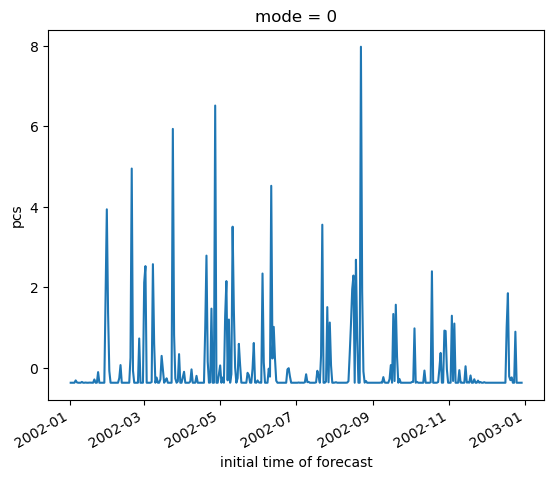

In [38]:
pclist[0][:,0].plot()

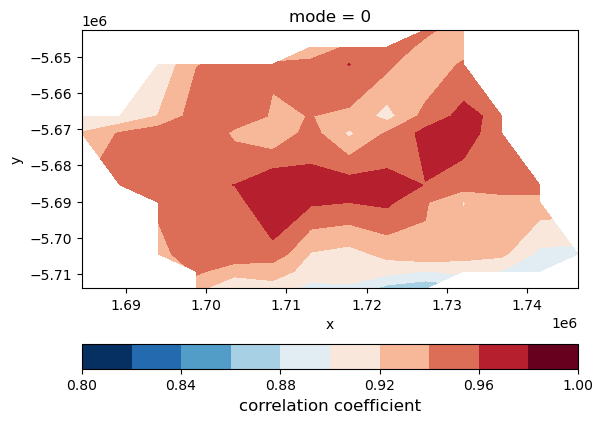

In [46]:
import cartopy.crs as ccrs
crs = ccrs.NorthPolarStereo()
crs_proj4 = crs.proj4_init

clevs = np.linspace(0.8, 1, 11)
fill = eoflist[1][0][np.where(np.isnan(eoflist[1][0])==False)].sortby('x').plot.contourf(levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False)
#ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
#ax.set_title('EOF1 expressed as correlation', fontsize=16)
#eoflist[1][0][np.where(np.isnan(eoflist[1][0])==False)].sortby('x').plot()

# Analysis for streamgage locations

In [22]:
copper = [i.sel(x = gage['longitude'][0],y=gage['latitude'][0], method= 'nearest') for i in f]
quad = [i.sel(x = gage['longitude'][1],y=gage['latitude'][1], method= 'nearest') for i in f]
lincoln = [i.sel(x = gage['longitude'][2],y=gage['latitude'][2], method= 'nearest') for i in f]
saline =  [i.sel(x = gage['longitude'][3],y=gage['latitude'][3], method= 'nearest') for i in f]

In [23]:
from scipy.stats import pearsonr
r = [pearsonr(lincoln[i].dropna('time'),quad[i].dropna('time'))[0] for i in range(len(quad))]

In [24]:
r

[0.9747545602383337,
 0.9594196103313123,
 0.9434570687491963,
 0.9666626559641414,
 0.9814775474918894,
 0.9650302375390978,
 0.9788049832176311,
 0.9949584766396975,
 0.9636393555890026,
 0.9877338155047053,
 0.8882000419399012,
 0.9830977565087871,
 0.9504190852706277,
 0.9683097634891398,
 0.9791393417630646,
 0.9179900123128859,
 0.9768028362451714,
 0.9758013259752772]

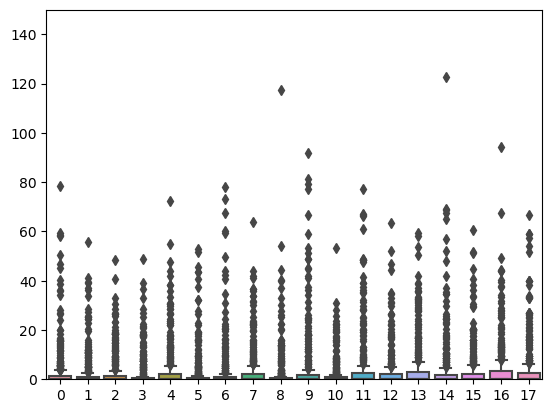

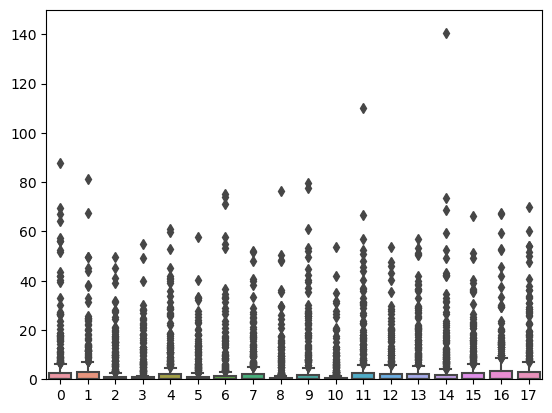

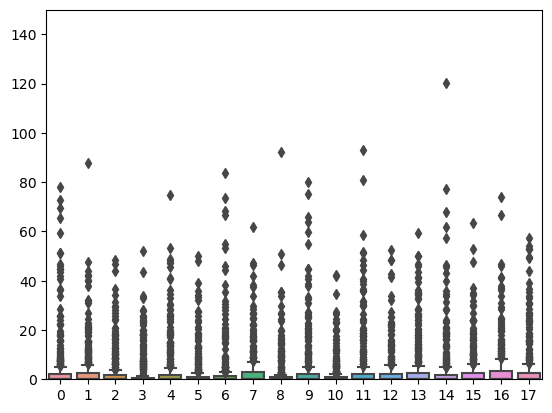

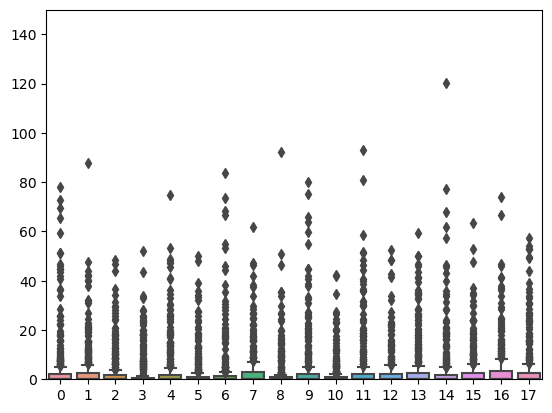

In [28]:
stns = [copper,quad,lincoln,saline]
import seaborn as sns
for j in [copper,quad,lincoln,saline]:
    #for i in j:
        #plt.plot(range(len(i[90:334].values)),i[90:334].values)
    sns.boxplot(j)
    plt.ylim(0,150)
    plt.show()

In [29]:
os.chdir('/data/dhence/a/pborse2/inputdata/srmflw_UC')
Ipeak = [pd.read_csv(i) for i in glob.glob('*.csv')]

In [30]:
len(copper[0][(copper[0]['time'].dt.month>=4) & (copper[0]['time'].dt.month<=11)].values)

244

In [49]:
disseason = [i[(pd.to_datetime(i['date']).dt.month>=6) & (pd.to_datetime(i['date']).dt.month<=9)] for i in Ipeak]

In [50]:
R2 = []
for i in range(len(disseason)):
    R=[]
    s=-1
    for j in range(2002,2020):
        s=s+1
        q = disseason[i][pd.to_datetime(disseason[i]['date']).dt.year==j][disseason[i].columns[2]]
        rain = stns[i][s][(stns[i][s]['time'].dt.month>=6) & (stns[i][s]['time'].dt.month<=9)]
        try:
            newdf=pd.DataFrame({'rain':rain.values[:243], 'strmflw': q.values[:243]})
            newdf.dropna()
            r2 = newdf.corr()
            R.append(r2)
        except:
            pass
    R2.append(R)

In [54]:
[R2[3][i]['strmflw']['rain'] for i in range(len(R2[3]))]

[0.09255148503941799,
 0.24538829955078612,
 0.04992927277055889,
 0.2638518125377641,
 0.04692439638756342,
 0.15157037634499435,
 0.07195523204298968,
 0.07954077760916319,
 0.018745661381919052,
 0.21084683005205074,
 0.10206647447363976]

In [217]:
len(R2[3])

11

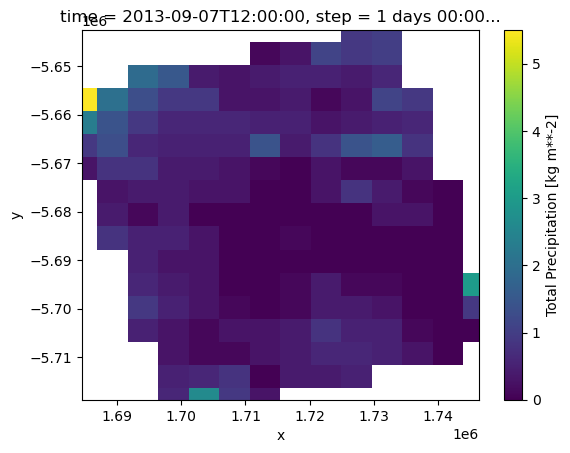

In [49]:
# ds1 = d.sel(time='2013-09-07')[0]
# b=np.where(np.isnan(ds1)==False) ### This step is for zooming in the masked out region by neglecting the NaN values
# ds1= ds1[b]
# ds1.sortby('x').plot()

In [6]:
from shapely.geometry import Polygon    
import numpy as np

lonmat= [np.array([1.702*(1e6), 1.702*(1e6), 1.705*(1e6), 1.7225*(1e6), 1.7225*(1e6)])]
latmat = [np.array([-5.6775*(1e6), -5.690*(1e6) , -5.696*(1e6), -5.695*(1e6),-5.6775*(1e6)])]


geom_list = [(x, y) for x, y in zip(lonmat, latmat)]

geom_list_2 = [Polygon(tuple(zip(x, y))) for x, y in geom_list]

In [7]:
geom_list_2

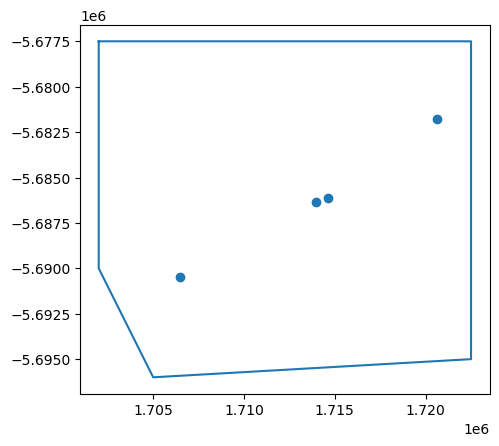

In [23]:
#champ.plot()
gage.plot()
plt.plot(*geom_list_2[0].exterior.xy)

In [18]:
poly = gpd.GeoDataFrame(index=[0],crs = crs_proj4 ,geometry = geom_list_2)

In [19]:
import salem
champcity = [i['tp'].salem.roi(shape=poly) for i in ncchamp1]

In [56]:
champavg = [i[(i['time'].dt.month>=4) & (i['time'].dt.month<=11)].mean(("y", "x")).dropna(dim='time') for i in champcity]

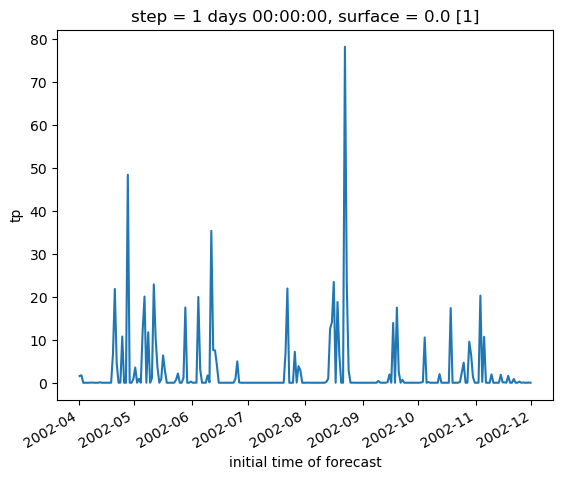

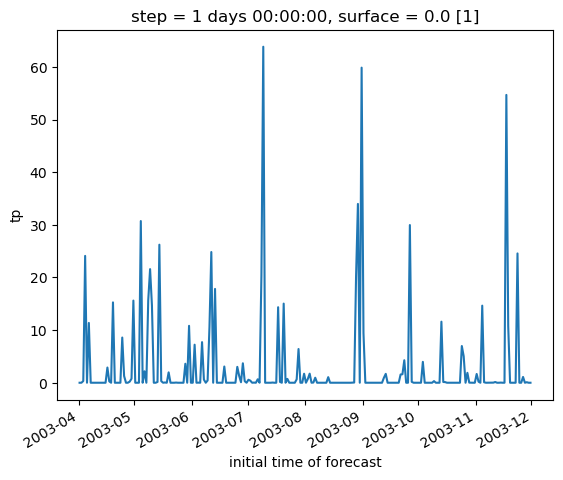

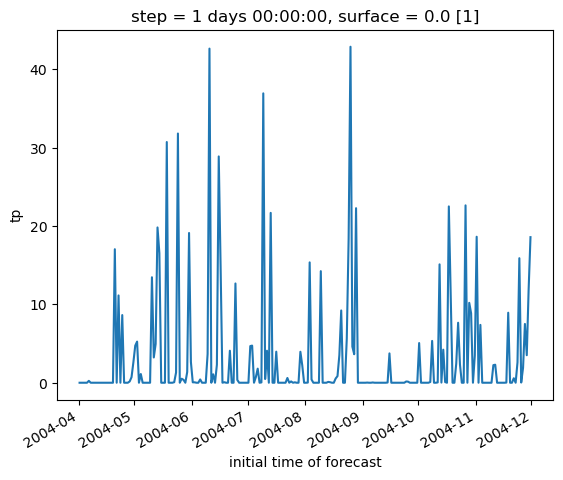

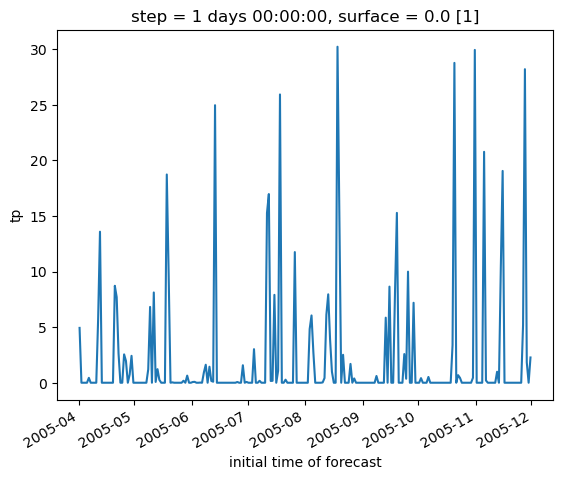

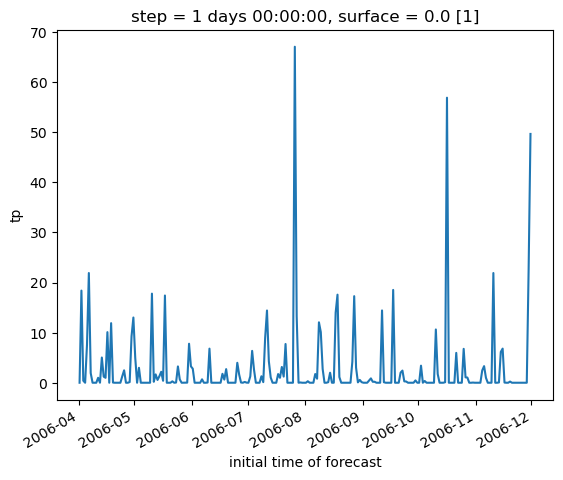

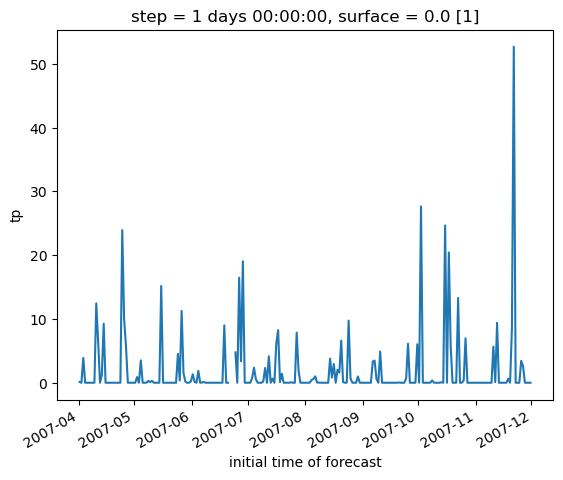

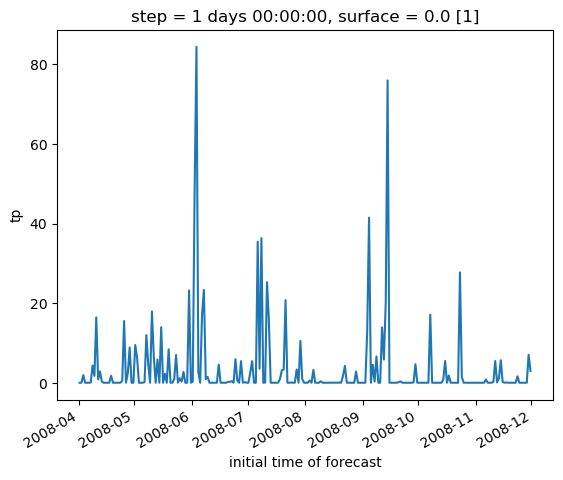

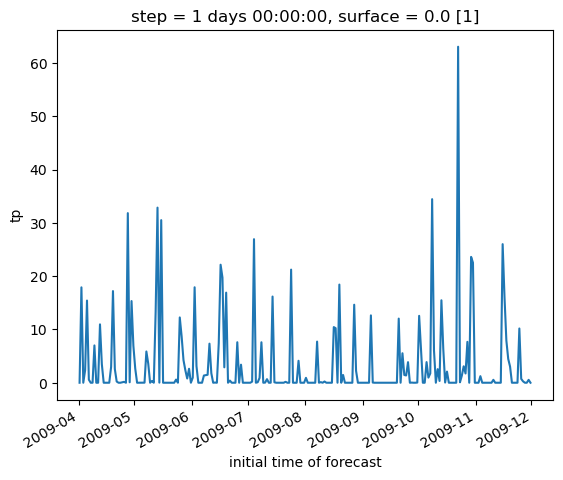

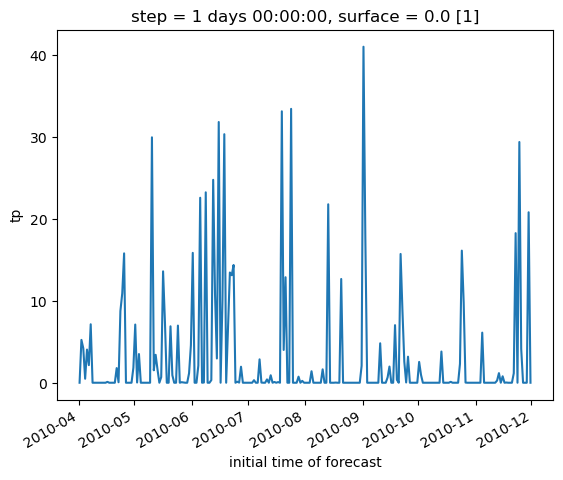

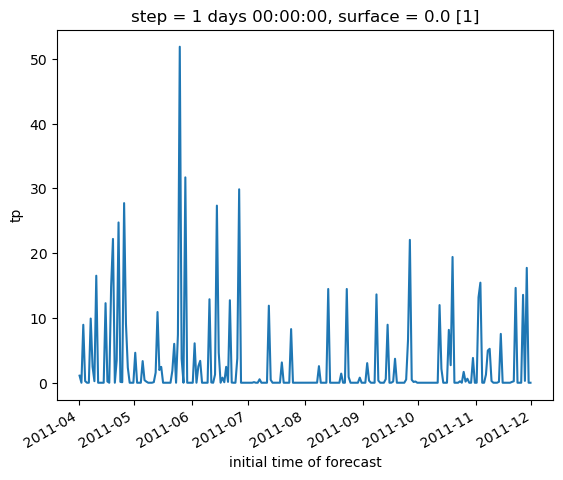

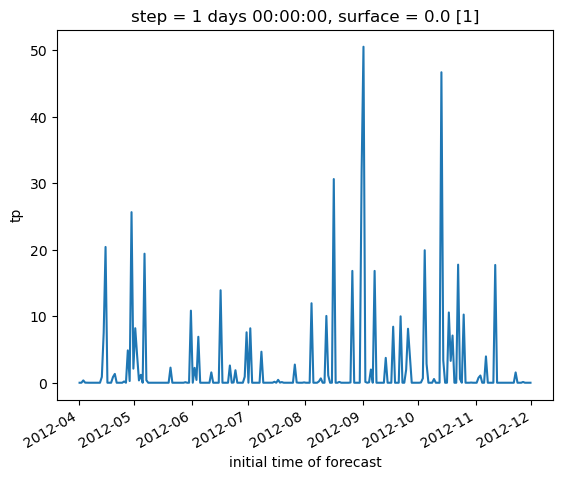

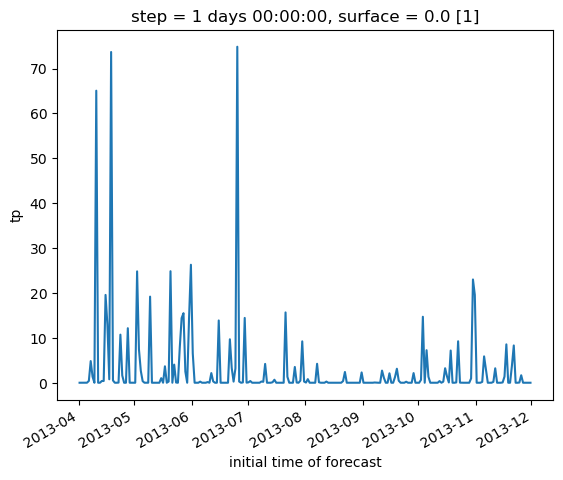

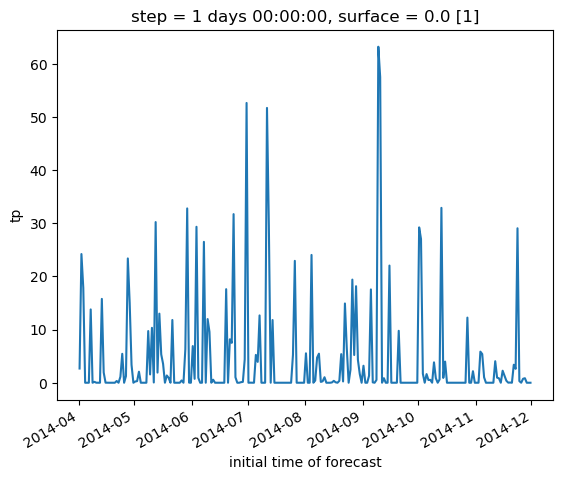

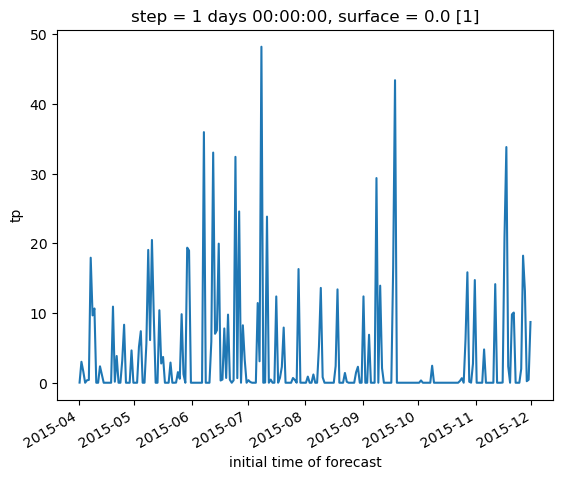

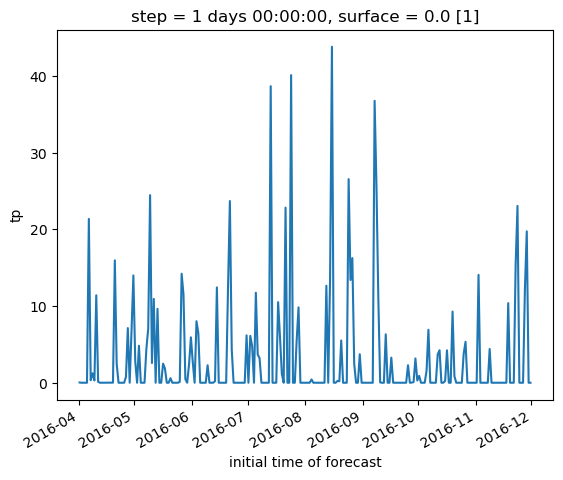

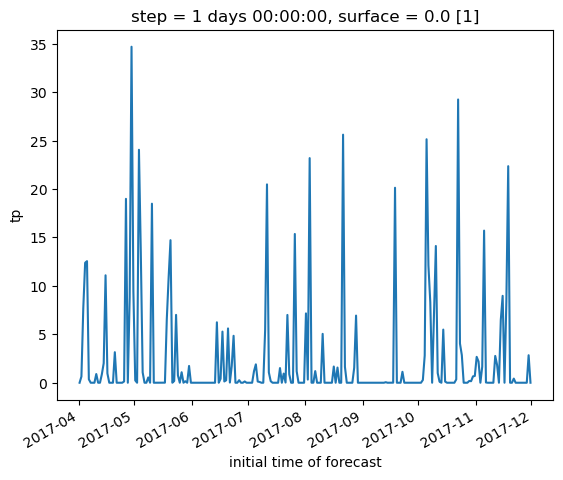

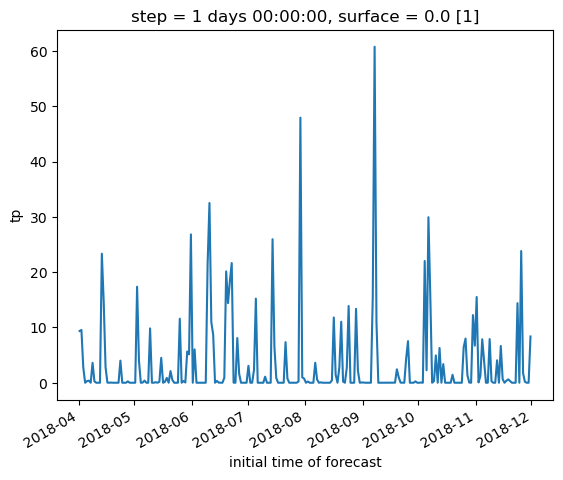

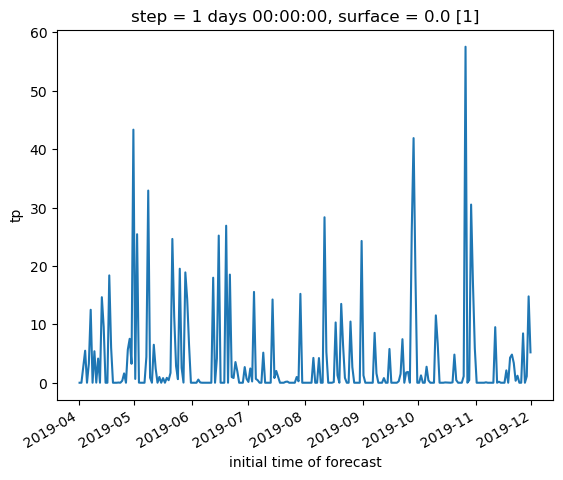

In [71]:
for i in champavg:
    i.plot()
    plt.show()

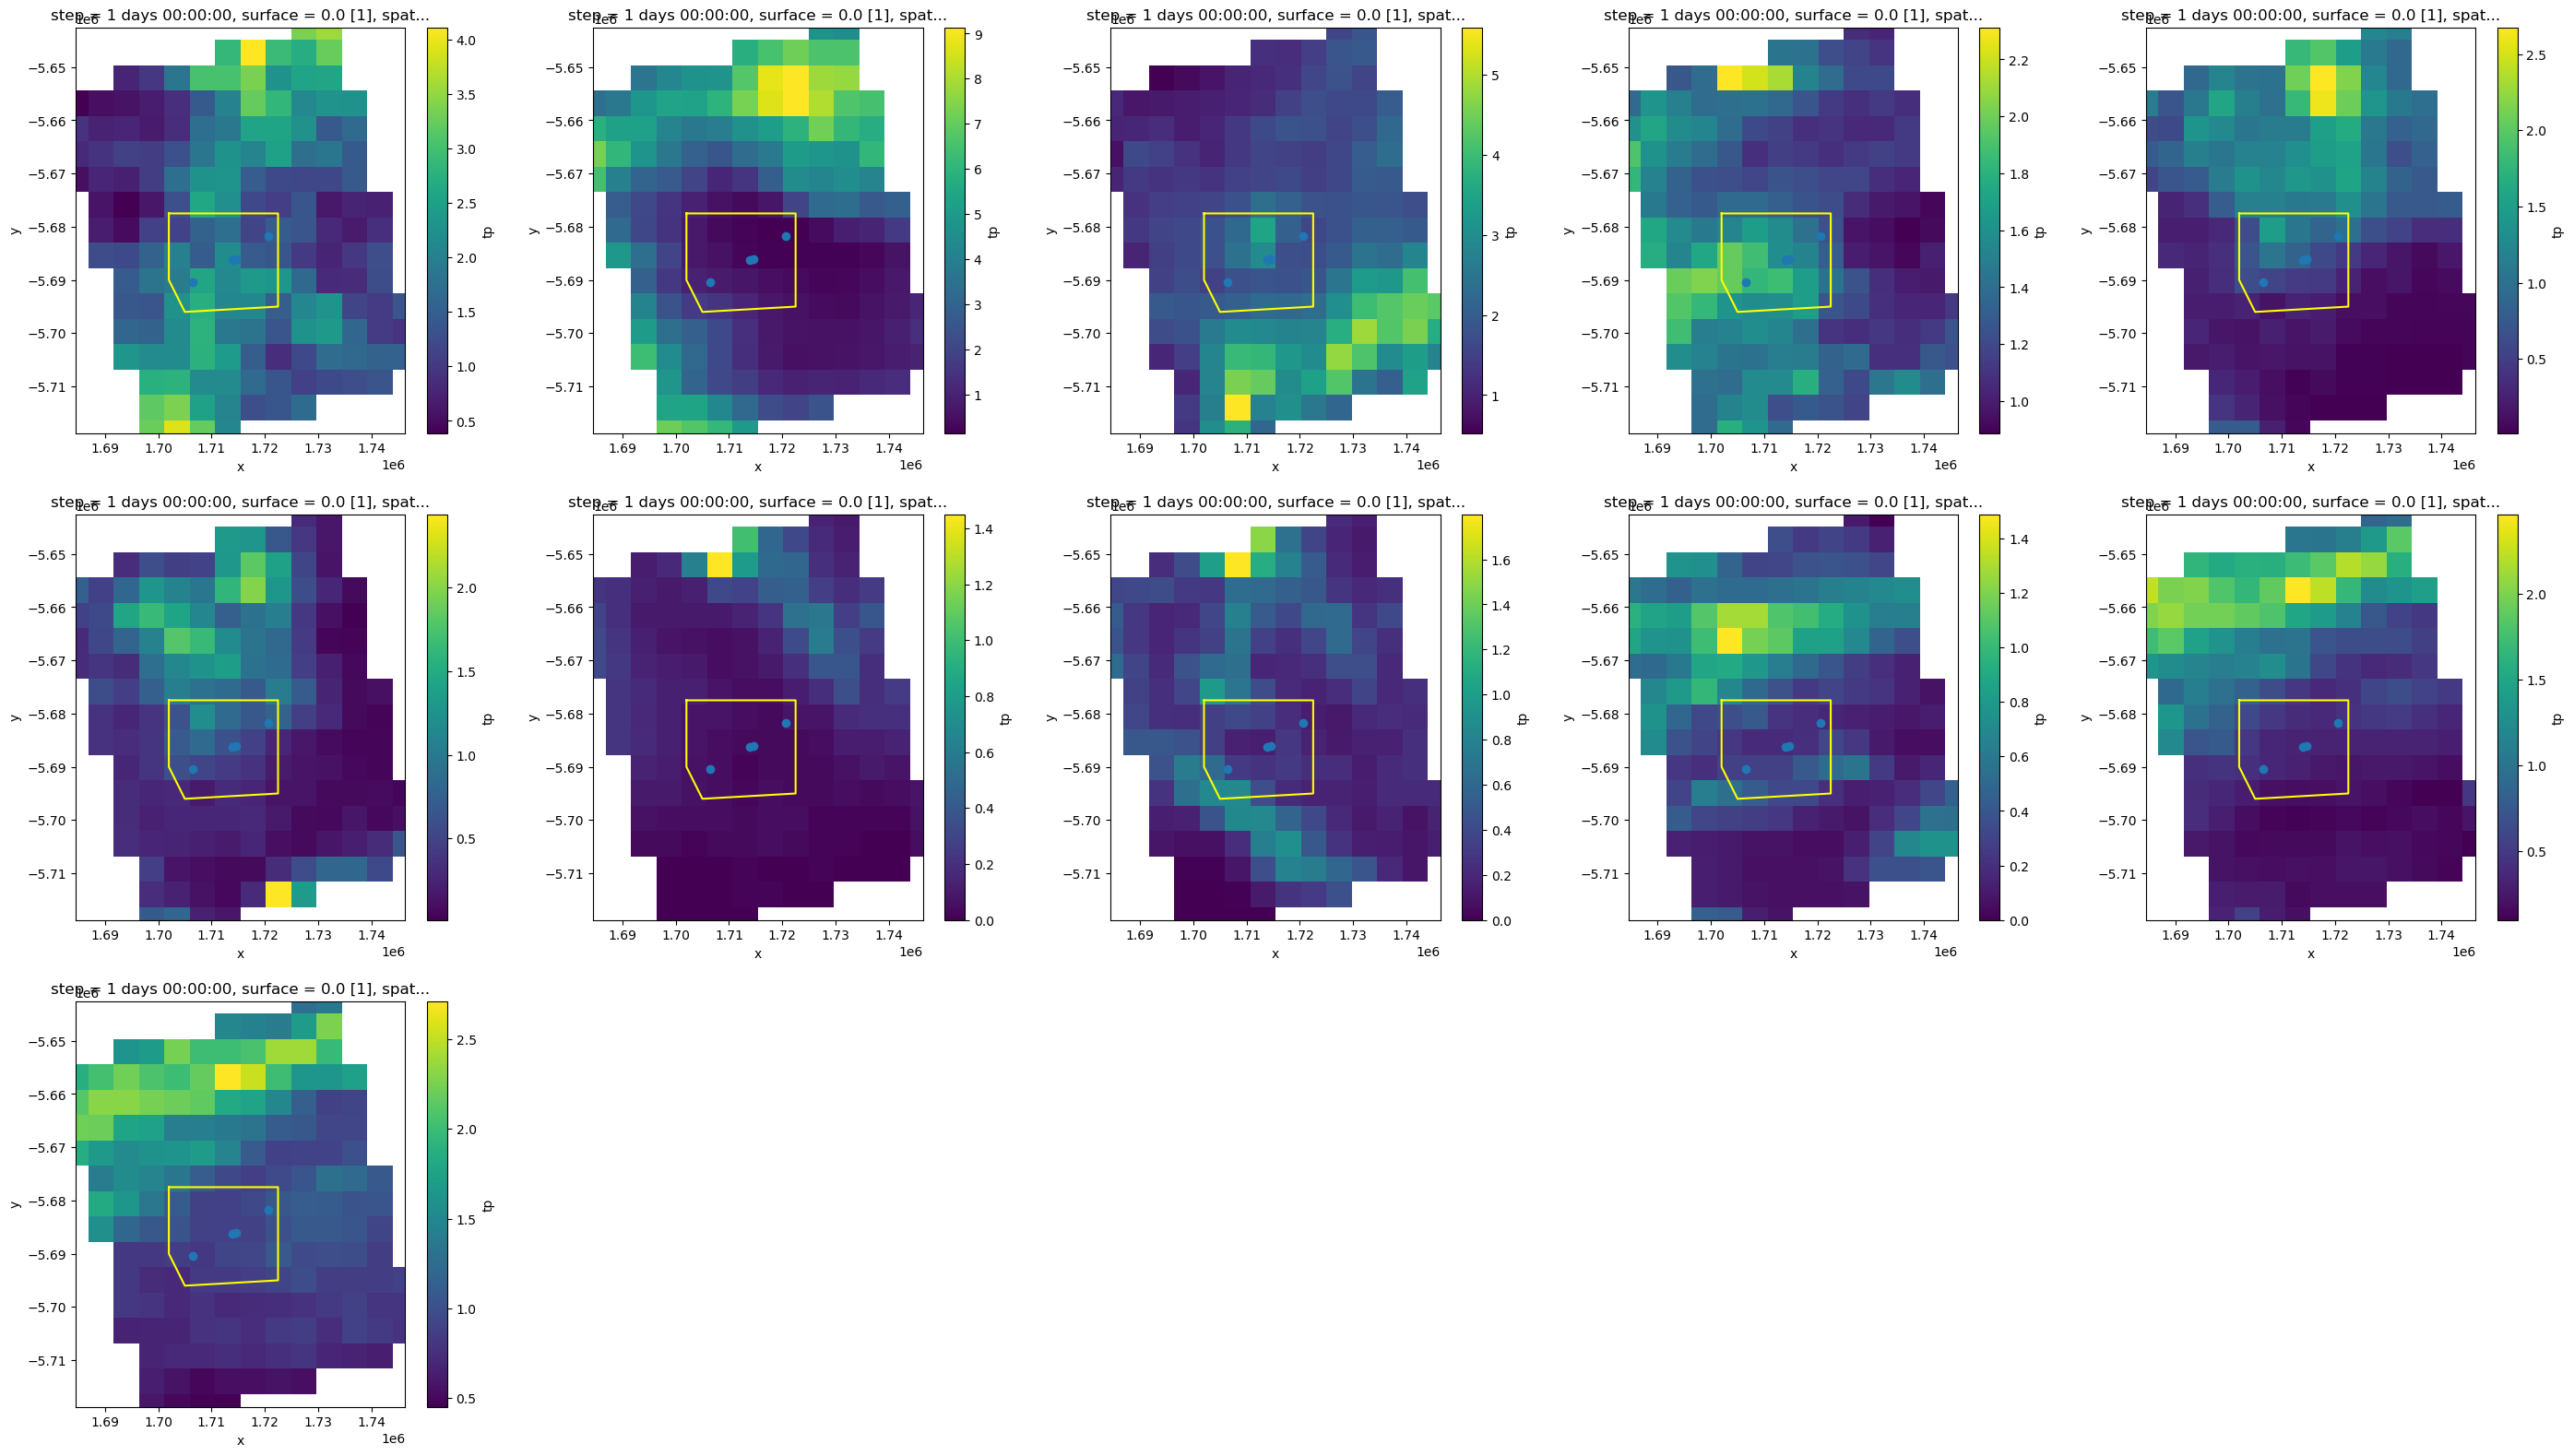

In [25]:
from matplotlib.pyplot import figure
from datetime import timedelta
figure(figsize=(35,40))
s=0
dlist = []
for i in batchdf['date']:
    if(ds.time.dt.year[1]==i.year):
        td=timedelta(21)
        s=s+1
        ax = plt.subplot(6, 5, s)
        ds2 = ds.sel(time= slice(str(i-td-timedelta(7))[:11],str(i-td)[:11])).mean(dim = "time") ####INPUT ALERT####
        dlist.append(ds2)
        try:
            b=np.where(np.isnan(ds2)==False) ### This step is for zooming in the masked out region by neglecting the NaN values
            ds2= ds2[b]
            ds2.sortby('x').plot(ax=ax) #### ds1[0] is selected because even after choosing a single date, the time dimension is not erased. so '0' represents selecting the time dimension
        except:
            pass
        #champ.boundary.plot(ax=ax, lw=0.5, color='white')
        ax.plot(*geom_list_2[0].exterior.xy,color='yellow')
        #mosshp.plot(ax=ax)
        gage.plot(ax=ax)
   

In [110]:
from ipynb.fs.full.ISWSdataset_Champaign import aprnov
csv=[pd.read_csv(f) for f in glob.glob("/data/dhence/a/pborse2/inputdata/ISWS_data/Champaign/*.csv")]

In [111]:
len(aprnov(csv)[3])
#len(champavg[0][pd.to_datetime(champavg[0]['time'].dt.date).isin(aprnov(csv)[3].index)])

/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

239

In [90]:
for i in range(len(champavg)):
#     print(len(champavg[i]),len(aprnov(csv)[i+3]))
    if(len(champavg[i])==len(aprnov(csv)[i+3])):
        k = pearsonr(aprnov(csv)[i+3]['TOTAL PRECIP oF'],champavg[i][pd.to_datetime(champavg[i]['time'].dt.date).isin(aprnov(csv)[i+3].index)])
#     else:
#         k = pearsonr(aprnov(csv)[i+3][aprnov(csv)[i+3].index.isin(pd.to_datetime(champavg[i]['time'].dt.date))]['TOTAL PRECIP oF'],champavg[i])
        print(k[0])

/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

0.6184072771068381
-0.004335992742402317


/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

0.6389678453828282
0.02722687640402198


/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

0.07592526209187939


/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

# Fixing the projection

In [10]:
# # Plot two datasets
# #fig, ax = plt.subplots(figsize=(15, 10))
# from cartopy.io.shapereader import FionaReader, BasicReader
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# fig = plt.figure(figsize=[12,5])
# crs = ccrs.NorthPolarStereo()

# crs_proj4 = crs.proj4_init
# ax = fig.add_subplot()

f=masked(flist[2])
f[3].sel(time="2004-6-11").plot(ax=ax,robust=True)
counties = f[2]
counties.boundary.plot(ax=ax, lw=0.5, color='orange')
counties[counties['STATE_NAME']=='Illinois'].boundary.plot(ax=ax, lw=0.5, color='white')

# You can use this to hide the numbers on both axis
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('')

AttributeError: partially initialized module 'fiona' has no attribute '_loading' (most likely due to a circular import)

# Calculations without manipulating nc files according to shp file

In [2]:
import netCDF4
import xarray as xr
import numpy as np
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.stats import pearsonr
import cartopy.crs as ccrs
crs = ccrs.NorthPolarStereo()
crs_proj4 = crs.proj4_init
os.chdir('/data/dhence/a/pborse2/inputdata/data.eol.ucar.edu/pub/download/extra/katz_data/stage4/daily_data')

In [1]:
from ipynb.fs.defs.Mosquitodataset1_Yearlybatchdata import yearlyfile, batch1, batchdf1
mos = yearlyfile("Mosquito yearly.xlsx",'U-C')[0]
mosyr = yearlyfile("Mosquito yearly.xlsx",'U-C')[1]
batch = batch1(mosyr,mos)
batchdf = batchdf1(mos)

In [3]:
fi = [f for f in glob.glob('*.nc')]
fi.sort()
# fiopen = [xr.open_dataset(i) for i in fi]
fiopen = xr.open_mfdataset(fi)

In [4]:
def hrap_from_latlon(lat, lon):
    ####### Calculate the latitude and longitude for a HRAP grid.
    raddeg = 57.29577951
    earthrad = 6371.2
    stdlon = 105.
    mesh_len = 4.7625
    tlat = 60. / raddeg
    
    R = earthrad*np.cos(lat/raddeg)*(1+np.sin(tlat))/(1+np.sin(lat/raddeg))
    
    x = R*np.cos((lon+15)/raddeg)
    y = R*np.sin((lon+15)/raddeg)
    
    hrap_x = 401+ (x/mesh_len)
    hrap_y = 1601+ (y/mesh_len)

    return hrap_x, hrap_y


In [5]:
#streamgage locations
latlon = pd.DataFrame({'longitude': [-88.1520, -88.3070, -88.21944, -88.22644], 'latitude': [40.1292, 40.0976, 40.11113, 40.11117]})

x = [hrap_from_latlon(latlon.iloc[i]['latitude'],latlon.iloc[i]['longitude'])[0] for i in range(len(latlon))]
y=  [hrap_from_latlon(latlon.iloc[i]['latitude'],latlon.iloc[i]['longitude'])[1] for i in range(len(latlon))]
latlon['longitude'] = x
latlon['latitude'] = y

geom = gpd.points_from_xy(latlon.longitude, latlon.latitude)
gage = gpd.GeoDataFrame(latlon, geometry=geom, crs = crs_proj4 )

<AxesSubplot:title={'center':'time = 2002-10-10T12:00:00, step = 1 days 00:00...'}, xlabel='x', ylabel='y'>

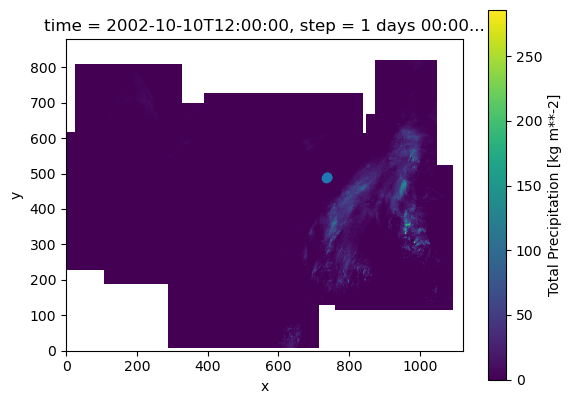

In [44]:
# ax=plt.subplot(1,1,1)
# fiopen['tp'].sel(time='2002-10-10').plot(ax=ax)
# gage.plot(ax=ax)

In [6]:
import cartopy.crs as ccrs
crs = ccrs.NorthPolarStereo()
crs_proj4 = crs.proj4_init

fiopen = fiopen.rio.write_crs(crs_proj4 , inplace=True)
fiopen['x']=fiopen.x
fiopen['y']=fiopen.y
fiopen=fiopen.set_index({'x':'x' ,'y':'y'})
fiopen.attrs['pyproj_srs'] = crs_proj4

In [7]:
copper = fiopen['tp'].sel(x = gage['longitude'][0],y=gage['latitude'][0], method= 'nearest') 
quad =  fiopen['tp'].sel(x = gage['longitude'][1],y=gage['latitude'][1], method= 'nearest') 
lincoln = fiopen['tp'].sel(x = gage['longitude'][2],y=gage['latitude'][2], method= 'nearest') 
saline = fiopen['tp'].sel(x = gage['longitude'][3],y=gage['latitude'][3], method= 'nearest') 

KeyboardInterrupt: 

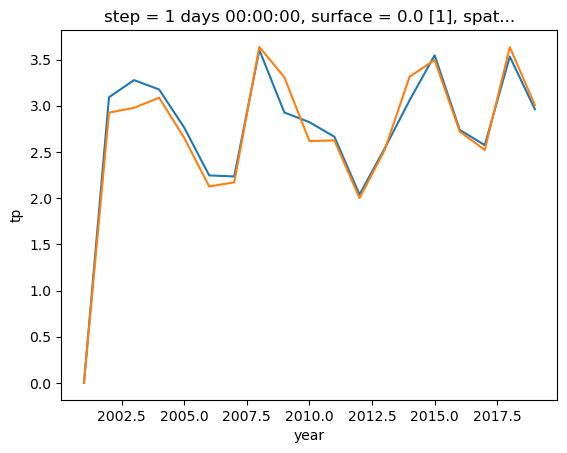

In [31]:
# stns = [copper,quad,lincoln,saline]
# import seaborn as sns
# for j in [copper,quad,lincoln,saline]:
#     j.groupby('time.year').mean().plot()
# #     plt.ylim(0,20)
# #     plt.show()

In [8]:
os.chdir('/data/dhence/a/pborse2/inputdata/srmflw_UC')
Ipeak = [pd.read_csv(i) for i in glob.glob('*.csv')]

In [9]:
disseason = [i[(pd.to_datetime(i['date']).dt.month>=6) & (pd.to_datetime(i['date']).dt.month<=9)] for i in Ipeak]

In [10]:
stns = [copper,quad,lincoln,saline]
R2 = []
for i in range(len(disseason)):
    R=[]
    s=-1
    for j in range(2002,2020):
        s=s+1
        q = disseason[i][pd.to_datetime(disseason[i]['date']).dt.year==j][disseason[i].columns[2]]
        rain = stns[i][stns[i]['time'].dt.year==j]
        rain = rain[(rain['time'].dt.month>=6) & (rain['time'].dt.month<=9)]
        try:
            newdf=pd.DataFrame({'rain':rain.values[:243], 'strmflw': q.values[:243]})
            newdf.dropna()
            r2 = newdf.corr()
            R.append(r2)
        except:
            pass
    R2.append(R)

In [71]:
[R2[2][i]['strmflw']['rain'] for i in range(len(R2[2]))]

[0.23821504208401256,
 0.31359017601225964,
 0.18880009102828385,
 0.5914072266627958,
 0.723030929084168,
 0.2056959570353318,
 0.45406909074918084,
 0.43031710785456456,
 0.47709398109950557,
 0.4466803699422969,
 0.5152313715259597,
 0.2569184638048897,
 0.3487989491724184,
 0.42026695268881675,
 0.5723924935419473,
 0.5742014164254916]

In [101]:
iswsx=hrap_from_latlon(40.084074, -88.240311)[0]
iswsy=hrap_from_latlon(40.084074, -88.240311)[1]

In [49]:
isws = [i['tp'].sel(x = iswsx,y=iswsy, method= 'nearest') for i in fiopen]

In [20]:
from ipynb.fs.full.ISWSdataset_Champaign import aprnov
csv=[pd.read_csv(f) for f in glob.glob("/data/dhence/a/pborse2/inputdata/ISWS_data/Champaign/*.csv")]
ppt = [aprnov(csv)[i] for i in range(3,len(aprnov(csv)))]

/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  },
/data/keeling/a/pborse2/Deanna Research/Research/ISWSdataset_Champaign.ipynb:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [51]:
for i in range(len(isws)):
#     print(len(isws[i]),len(aprnov(csv)[i+3]))
    dat = isws[i][pd.to_datetime(isws[i]['time'].dt.date).isin(ppt[i].index)]['time']
    k = pearsonr(ppt[i][ppt[i].index.isin(dat.dt.date.values)]['TOTAL PRECIP oF'],isws[i][pd.to_datetime(isws[i]['time'].dt.date).isin(dat.dt.date.values)])
#     else:
#         k = pearsonr(aprnov(csv)[i+3][aprnov(csv)[i+3].index.isin(pd.to_datetime(champavg[i]['time'].dt.date))]['TOTAL PRECIP oF'],champavg[i])
    print(k[0])

-0.022666333073400963
-0.059300659568713415
0.7966048572239057
-0.003362526768450366
-0.001477899119199405


ValueError: array must not contain infs or NaNs

In [11]:
usgs = pd.read_parquet('/data/dhence/a/pborse2/inputdata/boneyard_ppt.parquet').fillna(0)
usgssum =usgs[['USGS:03337000:00045:00000']].groupby(usgs.index.date).sum() 
usgssum['USGS:03337000:00045:00000'] = usgssum['USGS:03337000:00045:00000'].values*25.4

In [12]:
usgssum.index = pd.to_datetime(usgssum.index)

2002
2003
2004
2005
2006
0.5692117843651602
0.527761593288627
2009
0.43545726880616714
0.36138534125588745
0.4897870979637914
0.3912314731689588
0.5940535392750984
0.4563638598337859
0.5458167788813646
0.3646447300152402
0.6316883184524051
0.5092137514606965


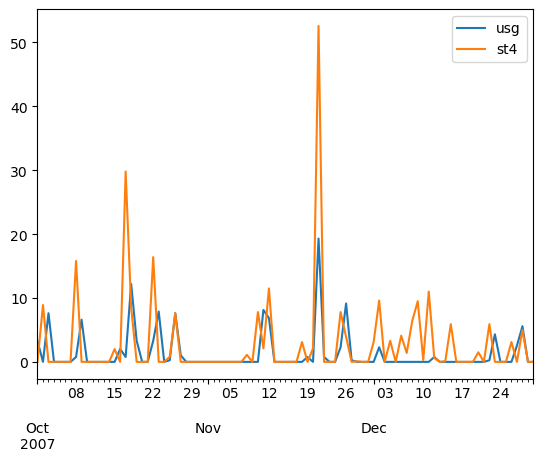

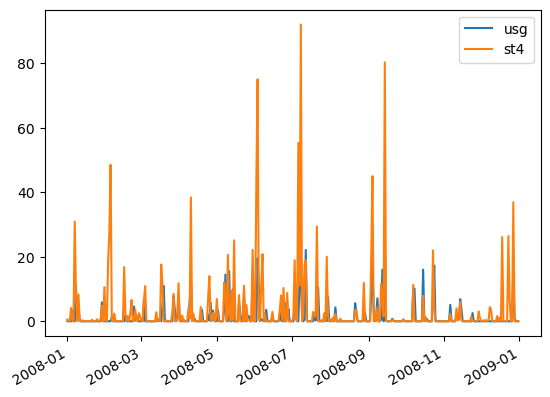

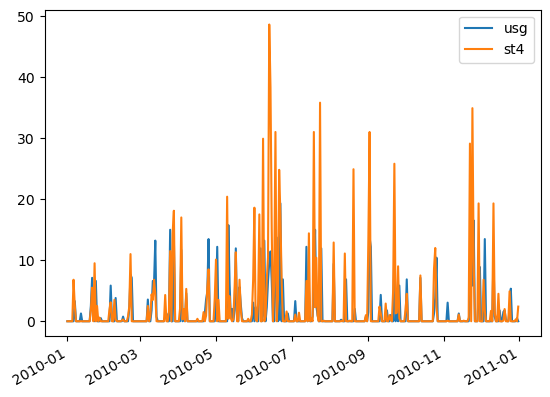

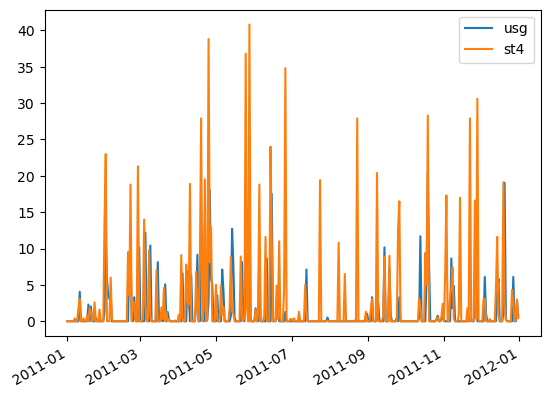

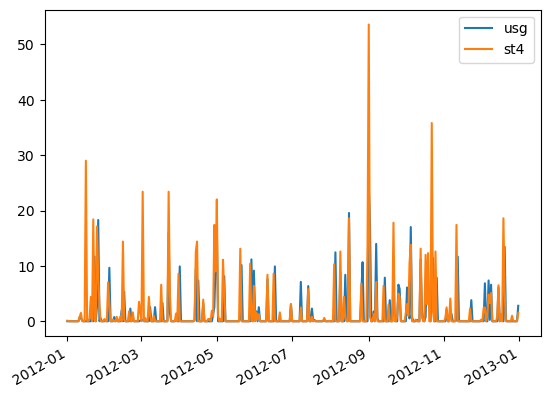

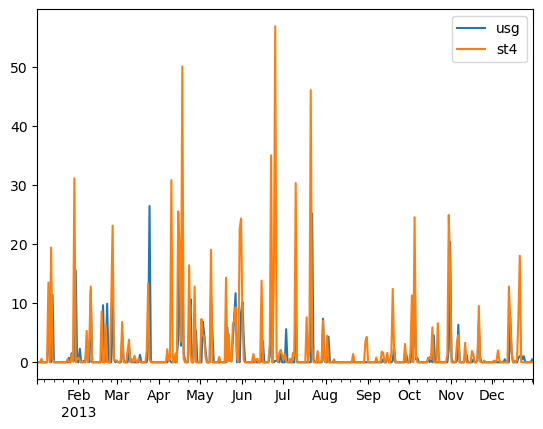

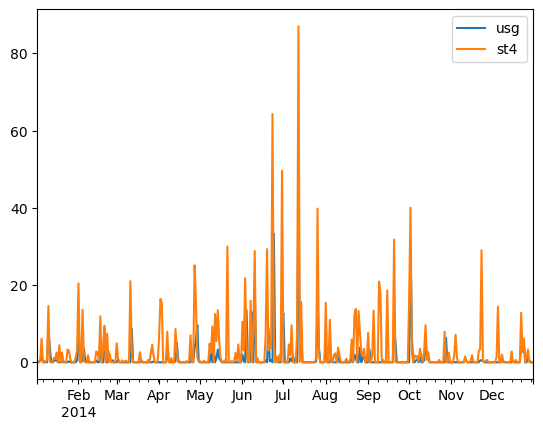

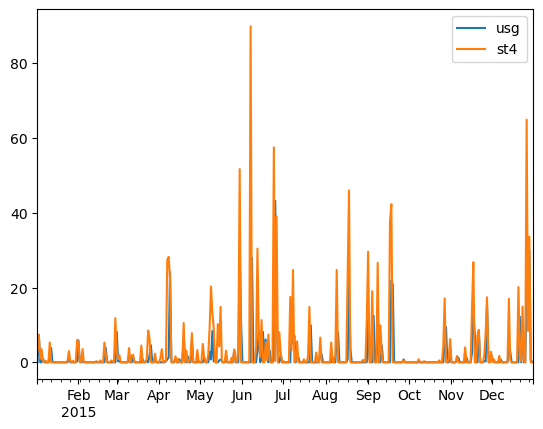

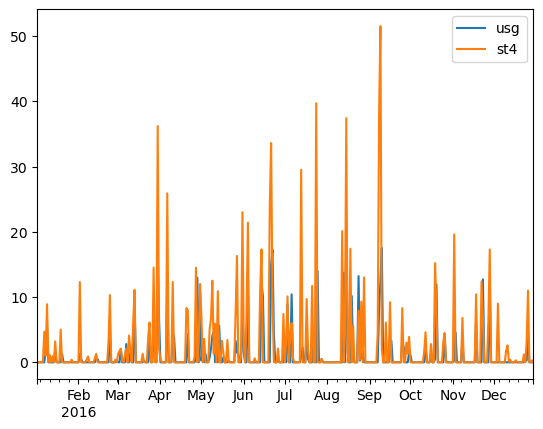

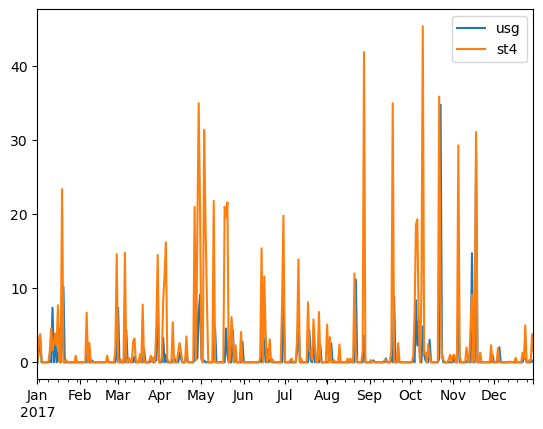

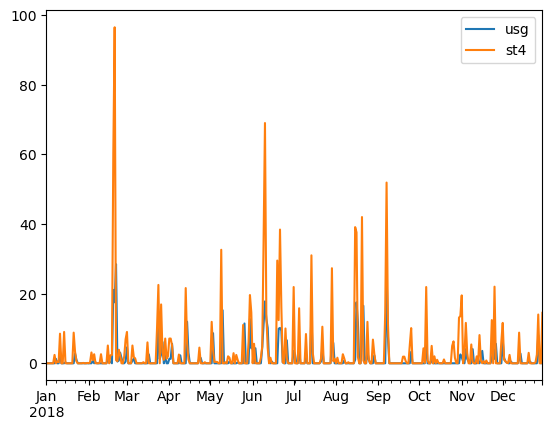

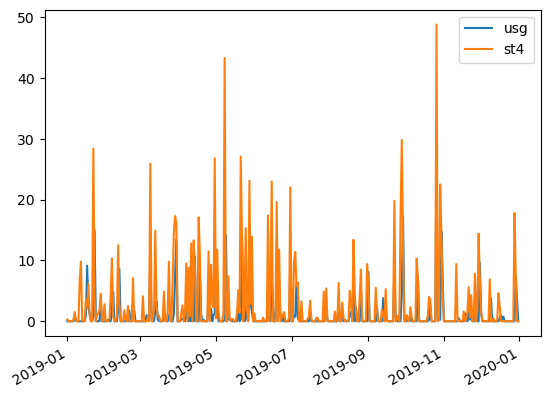

In [13]:
for i in range(2002,2020):
    quady = quad[quad['time'].dt.year==i]
    dat = usgssum[pd.to_datetime(usgssum.index).isin(pd.to_datetime(quady['time'].dt.date))].index
    try:
        usg = usgssum[usgssum.index.isin(dat)]['USGS:03337000:00045:00000']
        st4 = quady[pd.to_datetime(quady['time'].dt.date).isin(dat)]
        df= pd.DataFrame({'usg':usg,'st4':st4})
        df = df.dropna()
        k = pearsonr(df['usg'],df['st4'])
        print(k[0])
        df.plot()
    except:
        print(i)

In [36]:
from shapely.geometry import Polygon    
import numpy as np


lonmatup = [np.array([734.5,737.5,737.5,734.5])]
latmatup = [np.array([488.25,488.25,490.5,490.5])]

geom_list = [(x, y) for x, y in zip(lonmatup, latmatup)]

geom_list_2 = [Polygon(tuple(zip(x, y))) for x, y in geom_list]

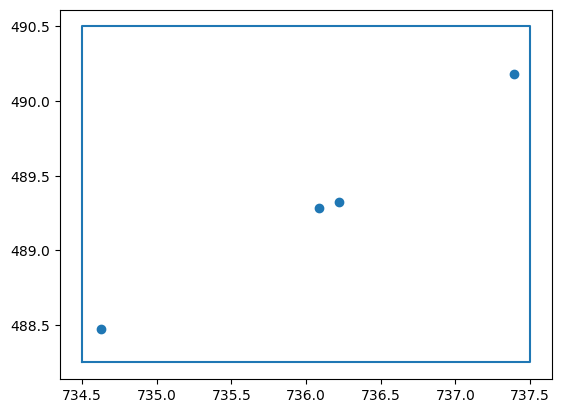

In [37]:
gage.plot()
plt.plot(*geom_list_2[0].exterior.xy)


In [38]:
poly1 = gpd.GeoDataFrame(index=[0],crs = crs_proj4 ,geometry = geom_list_2)

In [115]:
fiopen

[<xarray.Dataset>
 Dimensions:      (time: 364, y: 881, x: 1121)
 Coordinates:
   * time         (time) datetime64[ns] 2001-12-31T12:00:00 ... 2002-12-29T12:...
     step         timedelta64[ns] 1 days
     surface      float64 0.0
     latitude     (y, x) float64 ...
     longitude    (y, x) float64 ...
     valid_time   (time) datetime64[ns] 2002-01-01T12:00:00 ... 2002-12-30T12:...
     spatial_ref  int64 0
   * x            (x) int64 0 1 2 3 4 5 6 ... 1114 1115 1116 1117 1118 1119 1120
   * y            (y) int64 0 1 2 3 4 5 6 7 8 ... 873 874 875 876 877 878 879 880
 Data variables:
     tp           (time, y, x) float32 ...
 Attributes:
     GRIB_edition:            1
     GRIB_centre:             kwbc
     GRIB_centreDescription:  US National Weather Service - NCEP 
     GRIB_subCentre:          4
     Conventions:             CF-1.7
     institution:             US National Weather Service - NCEP 
     history:                 2022-07-28T18:20 GRIB to CDM+CF via cfgrib-0.9.1...


In [8]:
champcity = fiopen['tp'].sel(x=slice(734.5,737.5),y=slice(488,490.5))

In [9]:
#Create a timeseries by taking spatial average of the data
cutempo = champcity.mean(('x','y'))[(champcity.time.dt.month>=4)&(champcity.time.dt.month<=11)] 

In [13]:
# from datetime import timedelta

# for j in range(1,29):
#     td = timedelta(j)
# #     try:
#     t = cutempo['time'][cutempo.time.dt.date.isin((batchdf['date']-td).dt.date)]
# #     print(t)
# #         batchdf[(batchdf['date']-td).dt.date.isin(t)]['lag-'+str(j)]= cutempo[cutempo['time'].isin(t)]
# #     except:
# #         print(len(t))

In [10]:
#Finding threshold ppt when mosquito batches appear 
from datetime import timedelta
lagdays=[]
for j in range(1,29):
    laglist=[]
    for i in mosyr:
        batch3 = batchdf[batchdf['date'].dt.year==i]
        ppt = cutempo[cutempo.time.dt.year==i]
        td = timedelta(j)
        ppt = ppt[ppt.time.dt.date.isin((batch3['date']-td).dt.date)]
        data = zip(ppt.values,batch3['batches'].values)
        laglist.append(list(zip(ppt.values,batch3['batches'].values,batch3['date'])))
        #print(list(zip(ppt.values,batch['batches'].values)))
    laglist = sum(laglist,[])
    #print(laglist)
    lag = pd.DataFrame(laglist,columns = ['lag'+str(j), 'batch','date'])        
    lagdays.append(lag)


In [20]:
lagdays[2]

lag3  batch       date
0     0.000000      1 2002-07-11
1     0.000000      2 2002-07-16
2     0.000000      3 2002-07-23
3     1.177778      3 2002-07-24
4    34.122223      1 2002-07-31
..         ...    ...        ...
141   7.333333      3 2018-08-31
142   0.000000      3 2018-09-07
143   0.000000      1 2018-09-14
144   0.000000      3 2018-09-21
145   0.000000      1 2018-10-05

[146 rows x 3 columns]

In [11]:
b=lagdays[0]['batch']
d = lagdays[0]['date']
# for i in lagdays:
#     i['batch'] = b
#     i = i.set_index('batch',inplace=True)
lagdf = pd.concat(lagdays,axis=1,sort=False)

In [12]:
lagdf['batch']=b
lagdf['date'] =d
lagdf = lagdf.drop(['batch','date'],axis=1)

In [13]:
lagdf = lagdf.join(b)
lagdf = pd.concat([lagdf,d],axis=1)

In [14]:
lagdf.set_index('date',inplace=True)

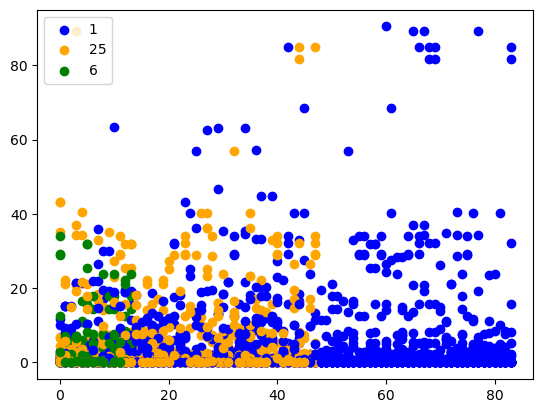

In [58]:
for i in lagdf.columns:
    plt.scatter(range(len(lagdf[(lagdf.batch==1)])),lagdf[(lagdf.batch==1)][i],color='blue')
    plt.scatter(range(len(lagdf[(lagdf.batch>=2)&(lagdf.batch<=5)])),lagdf[(lagdf.batch>=2)&(lagdf.batch<=5)][i],color='orange')
    plt.scatter(range(len(lagdf[(lagdf.batch>=6)])),lagdf[(lagdf.batch>=6)][i],color='green')
    plt.legend([1,25,6])


In [16]:

# for i in range(len(lagdf.columns)):
#     lagdf['ppt_weight-'+str(i+1)] =i*lagdf[lagdf.columns[i]]

In [20]:
# lagdf['totpptweight']= lagdf[lagdf.columns[28:]].sum(axis=1)

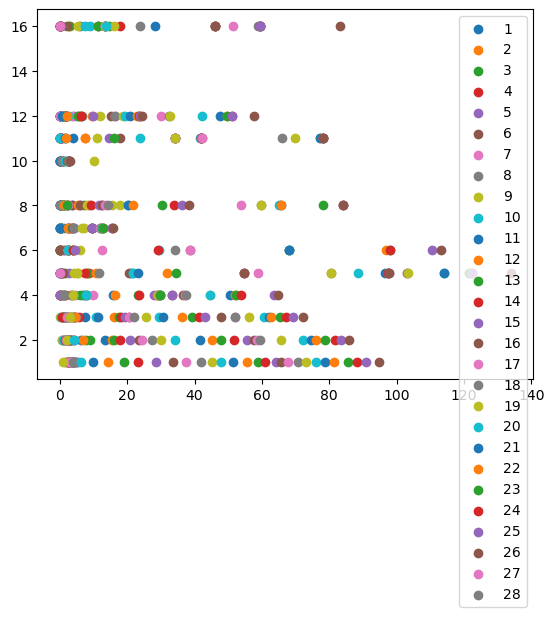

In [19]:
lagdf = lagdf.sort_values(by='batch')
# plt.boxplot(lagdf['totpptweight'].groupby(lagdf.index).apply(list))
# plt.show()
# for i in range(1,len(lagdf.columns)):
#     plt.boxplot(lagdf[lagdf.columns[:i]].sum(axis=1).groupby(lagdf.index).apply(list))
#     plt.show()
# for i in range(1,len(lagdf.columns)):
#     plt.scatter(lagdf[lagdf.columns[:i]].sum(axis=1).groupby(lagdf.index).mean(),list(dict.fromkeys(lagdf.index)))
#     plt.show()
for i in range(len(lagdf.columns)):
    plt.scatter(lagdf[lagdf.columns[i]].groupby(lagdf.batch).mean(),list(dict.fromkeys(lagdf.batch)))
plt.legend(range(1,29))

/tmp/ipykernel_41849/273876108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lagdf.groupby(lagdf.index.year)['lag2'].apply(list)[i],hist=False,ax=ax)
/tmp/ipykernel_41849/273876108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lagdf.groupby(lagdf.index.year)['lag2']

KstestResult(statistic=0.7142857142857143, pvalue=1.94917204154521e-05)
KstestResult(statistic=0.625, pvalue=0.08702408702408701)
KstestResult(statistic=0.5454545454545454, pvalue=0.0746606334841629)
KstestResult(statistic=0.5, pvalue=0.7714285714285716)


/tmp/ipykernel_41849/273876108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lagdf.groupby(lagdf.index.year)['lag2'].apply(list)[i],hist=False,ax=ax)
/tmp/ipykernel_41849/273876108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lagdf.groupby(lagdf.index.year)['lag2']

KstestResult(statistic=0.6086956521739131, pvalue=0.0002676202342498227)
KstestResult(statistic=0.875, pvalue=0.002486402486402486)
2008
KstestResult(statistic=1.0, pvalue=0.028571428571428577)
KstestResult(statistic=0.8333333333333334, pvalue=0.025974025974025972)
KstestResult(statistic=0.75, pvalue=0.018648018648018645)


/tmp/ipykernel_41849/273876108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lagdf.groupby(lagdf.index.year)['lag2'].apply(list)[i],hist=False,ax=ax)
/tmp/ipykernel_41849/273876108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lagdf.groupby(lagdf.index.year)['lag2']

KstestResult(statistic=0.8888888888888888, pvalue=0.0007404360345536814)
KstestResult(statistic=0.8181818181818182, pvalue=0.0006549178375803762)
KstestResult(statistic=0.5, pvalue=0.7714285714285716)
KstestResult(statistic=0.6666666666666666, pvalue=0.14285714285714285)
KstestResult(statistic=1.0, pvalue=0.007936507936507936)


/tmp/ipykernel_41849/273876108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lagdf.groupby(lagdf.index.year)['lag2'].apply(list)[i],hist=False,ax=ax)
/tmp/ipykernel_41849/273876108.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lagdf.groupby(lagdf.index.year)['lag2']

KstestResult(statistic=0.6666666666666666, pvalue=0.14285714285714285)
KstestResult(statistic=0.6666666666666666, pvalue=0.007859014050964517)


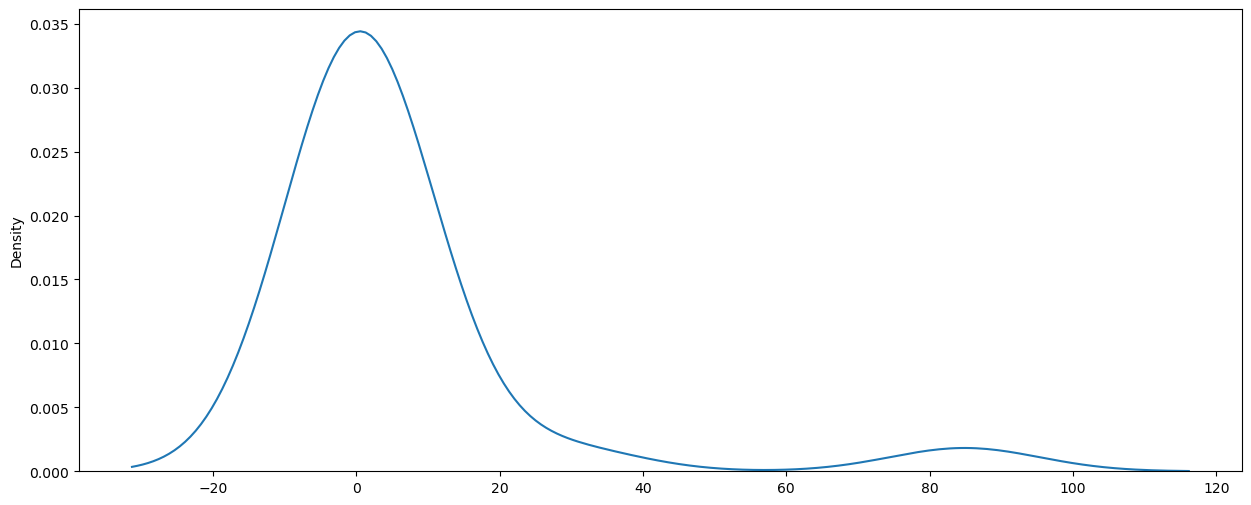

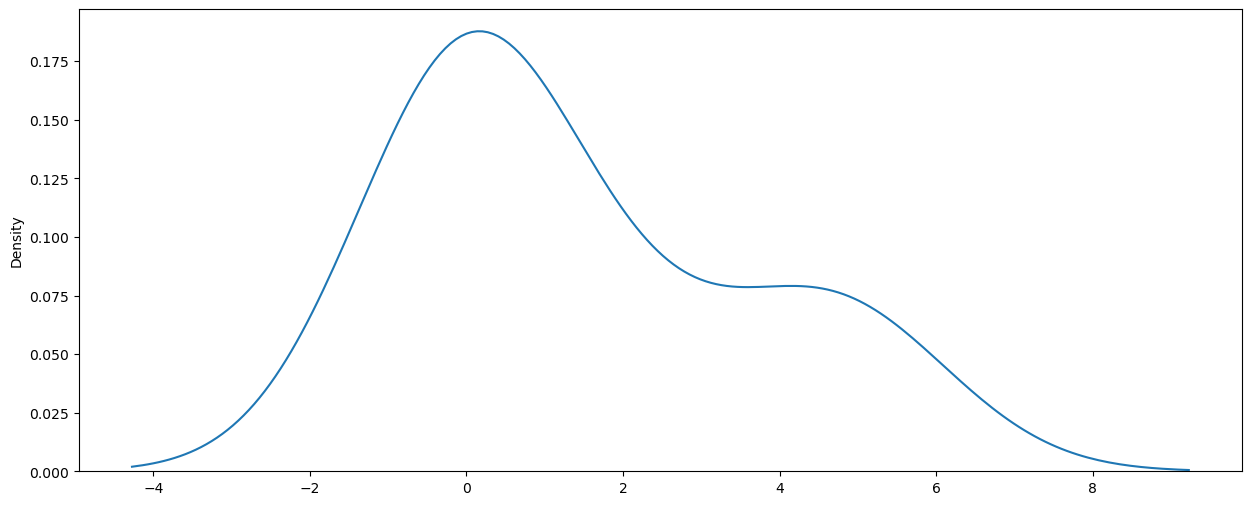

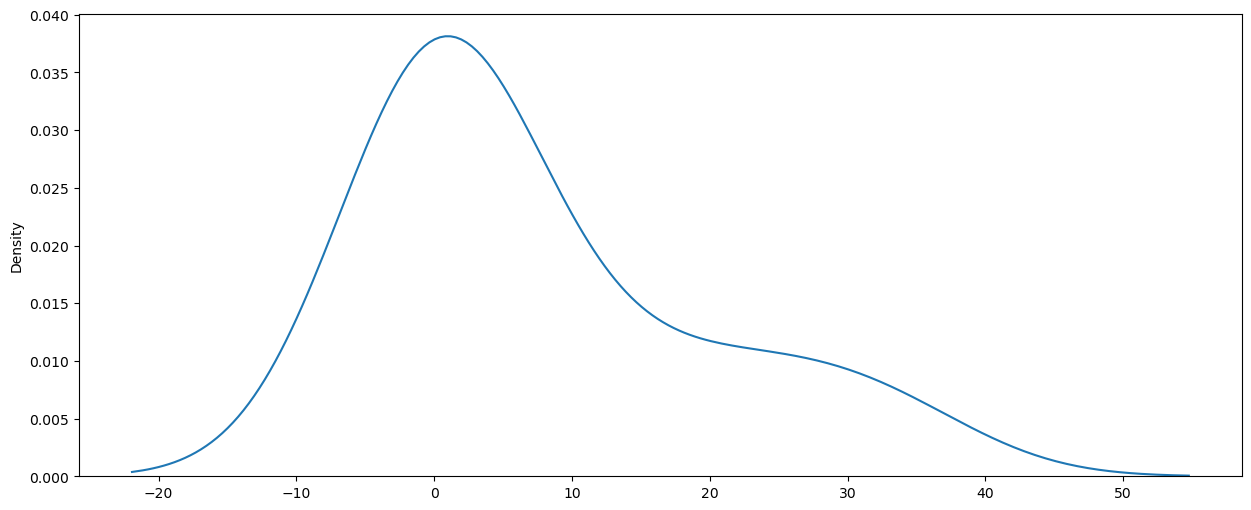

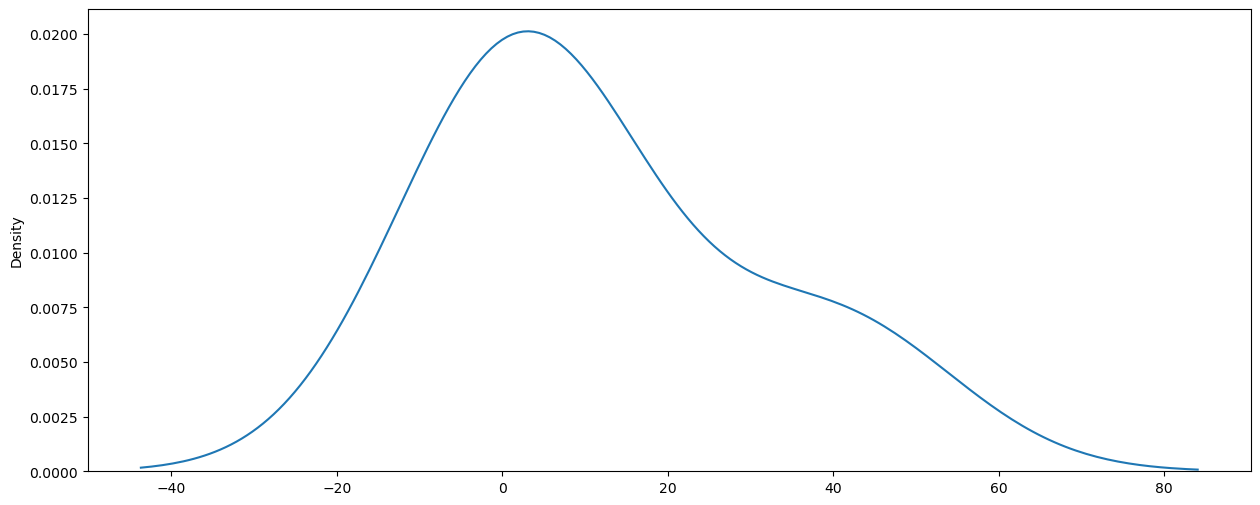

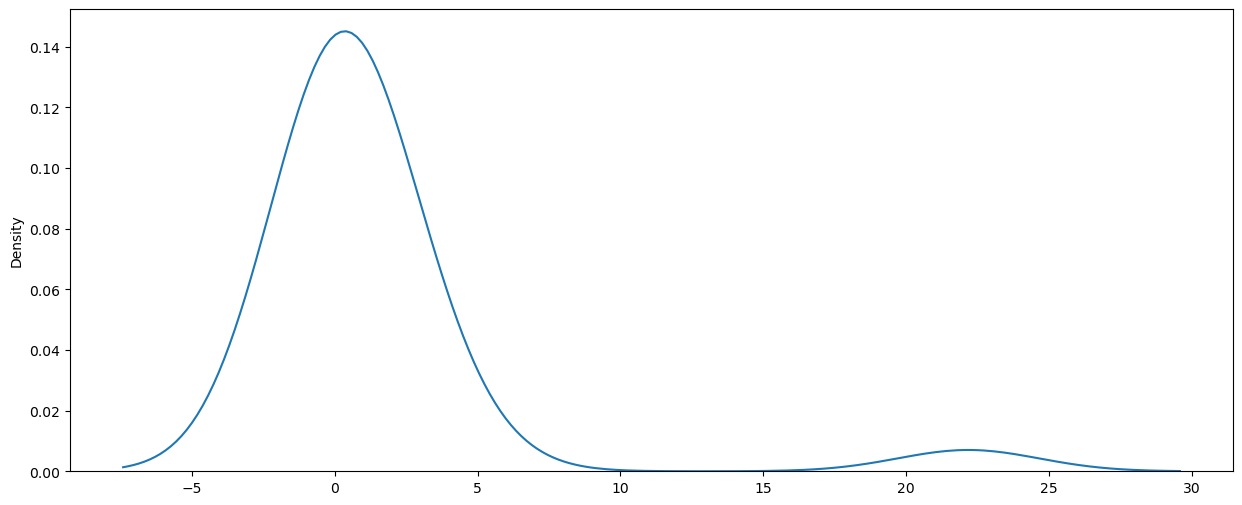

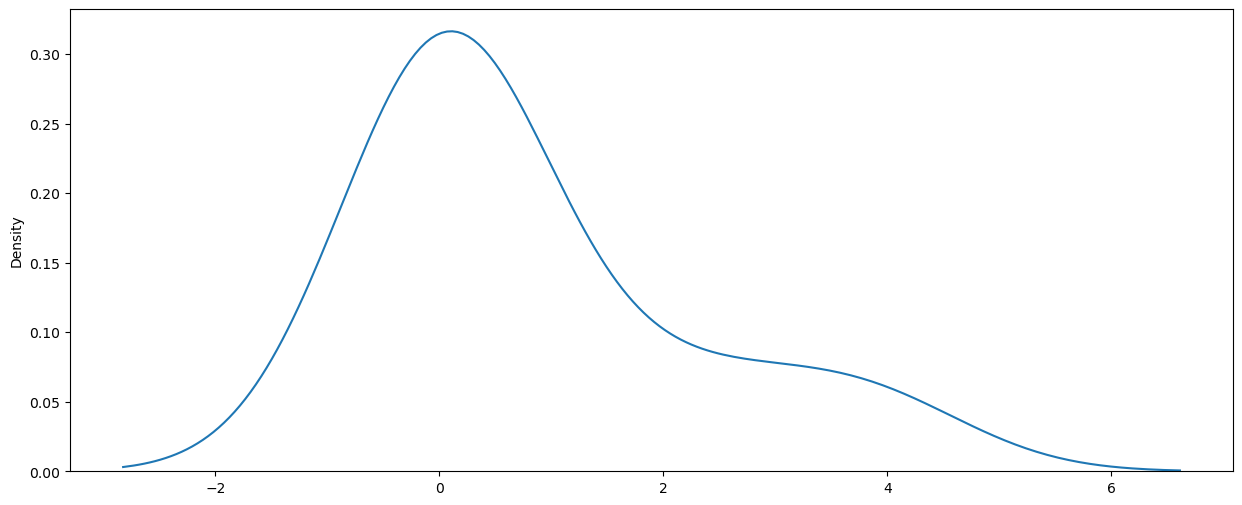

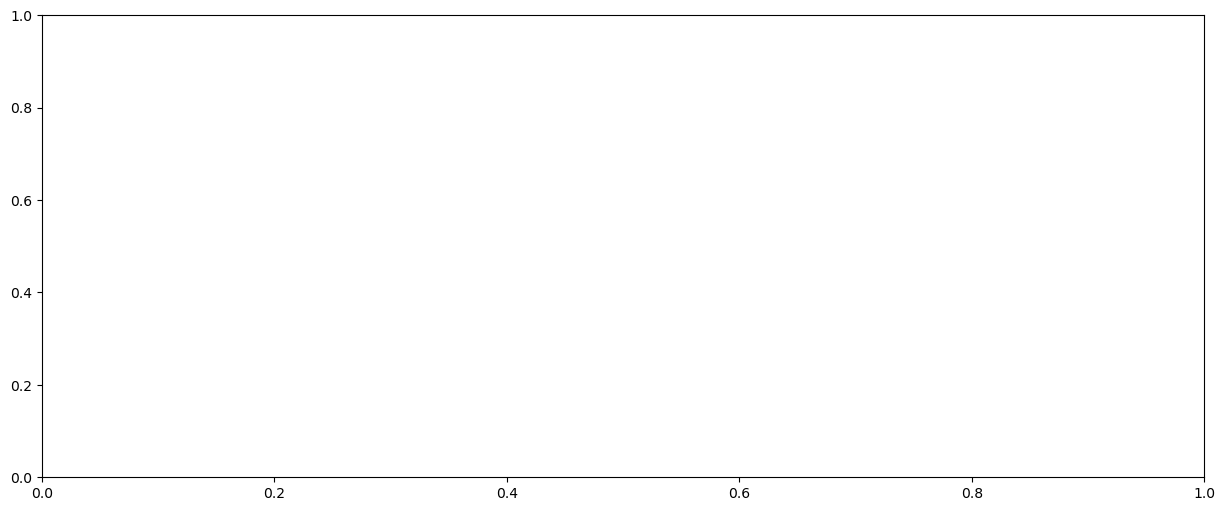

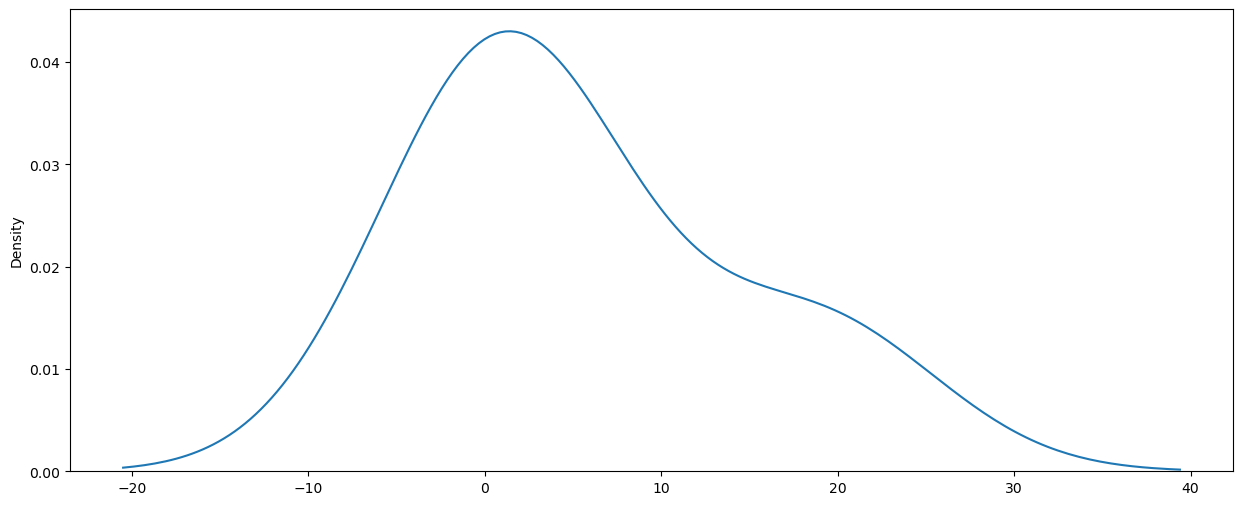

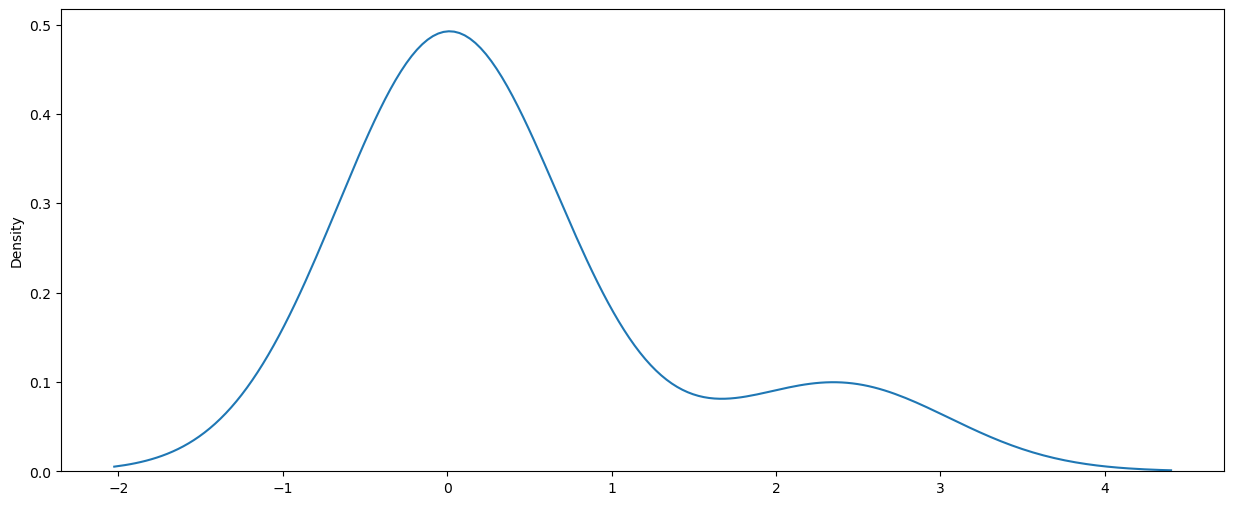

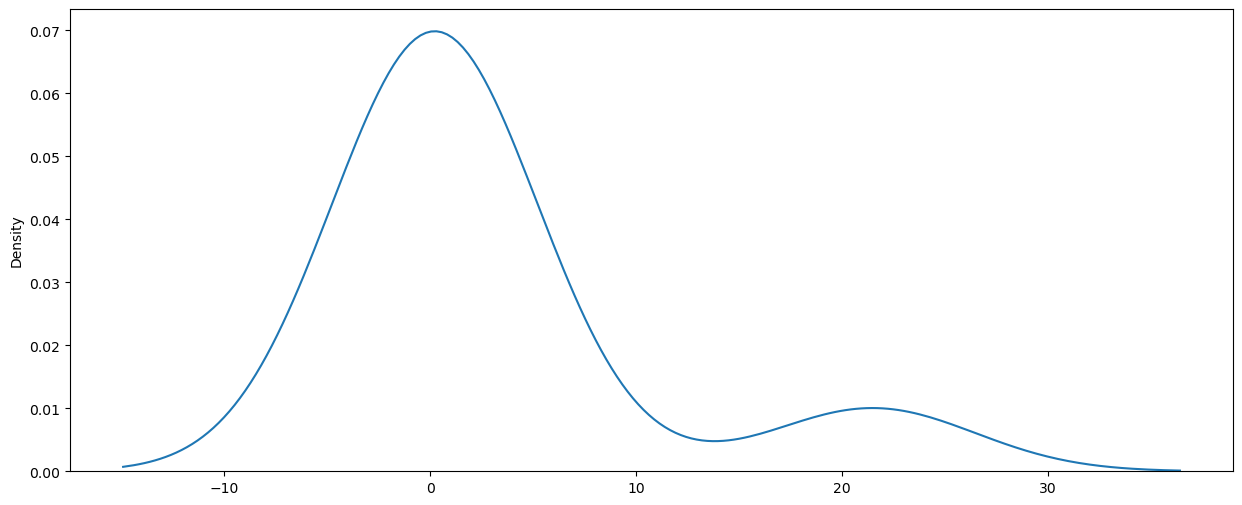

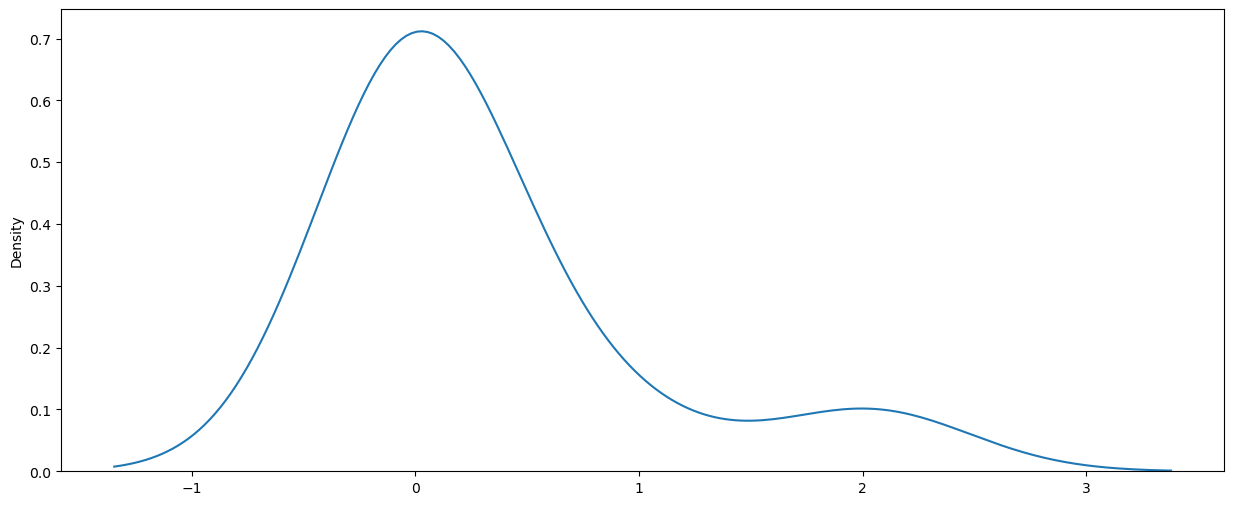

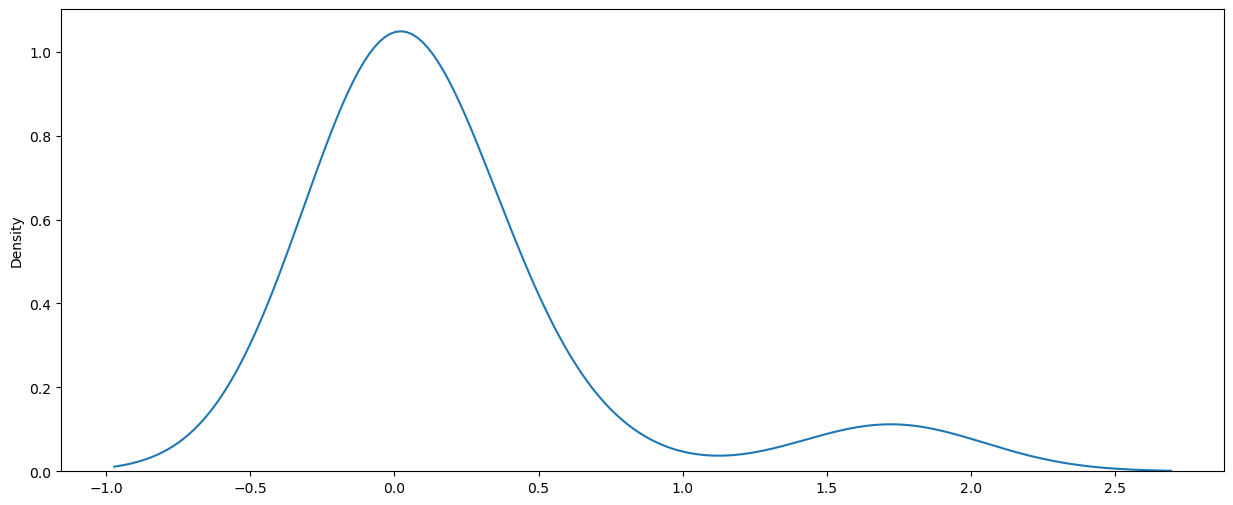

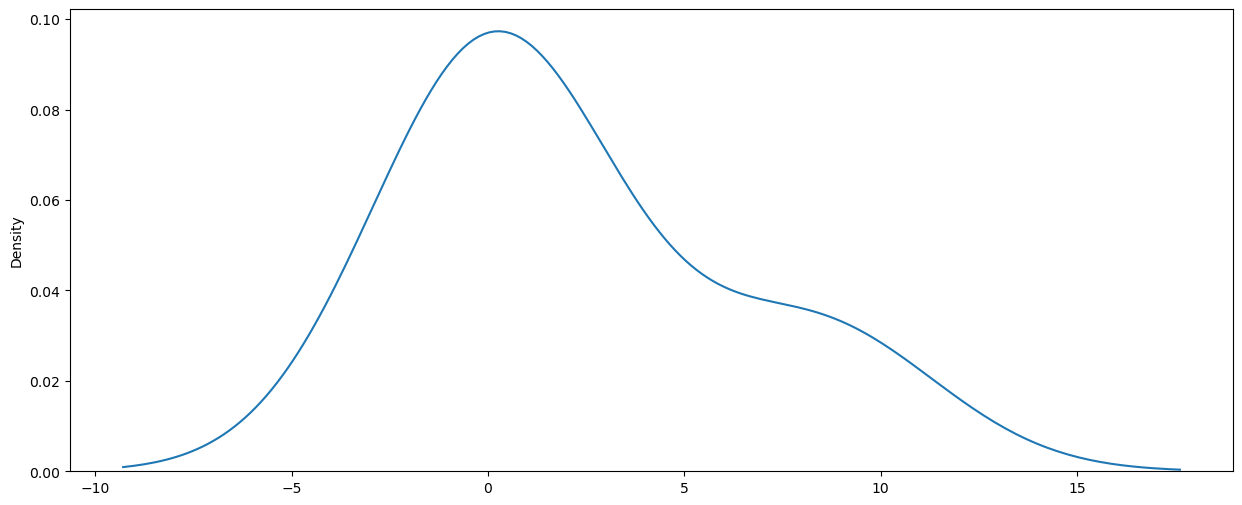

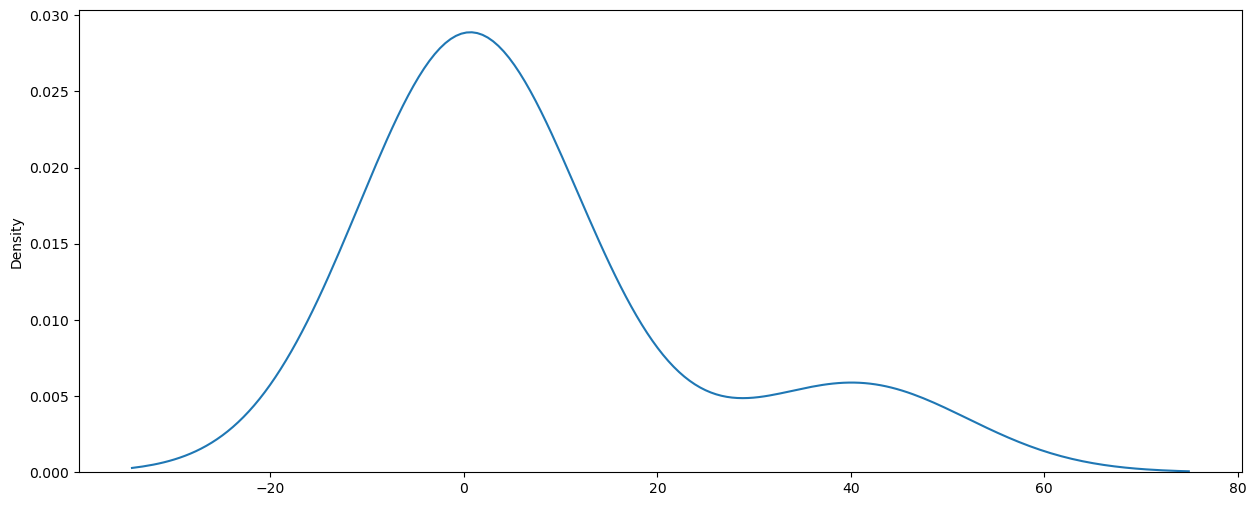

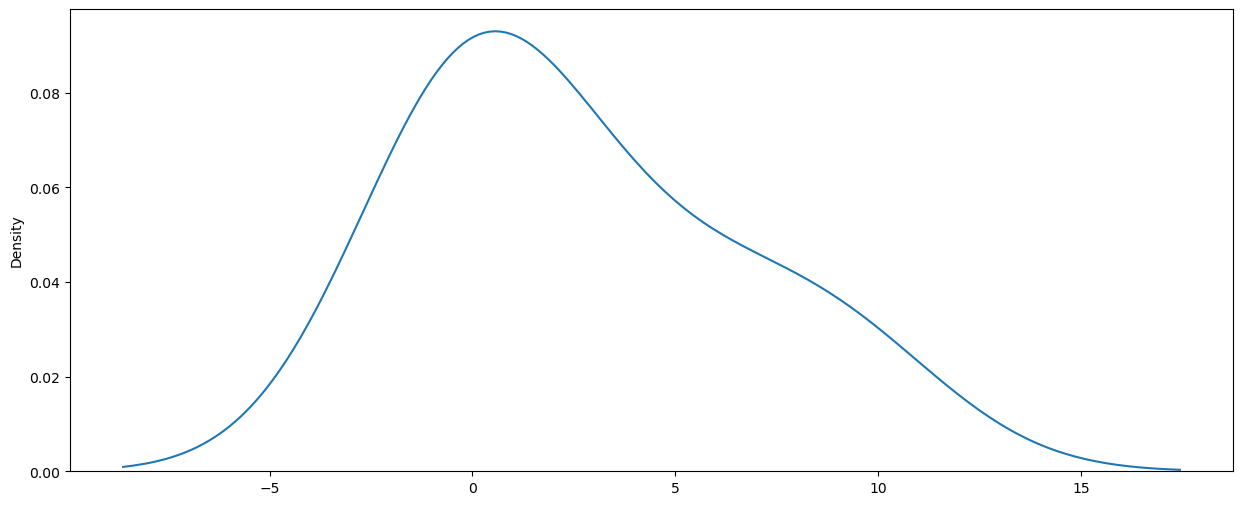

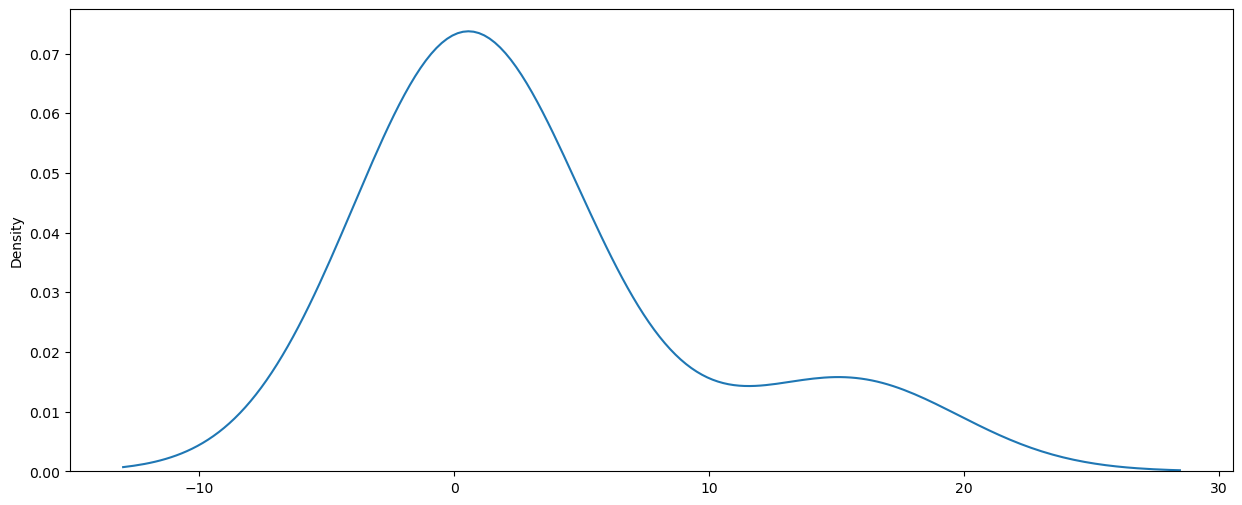

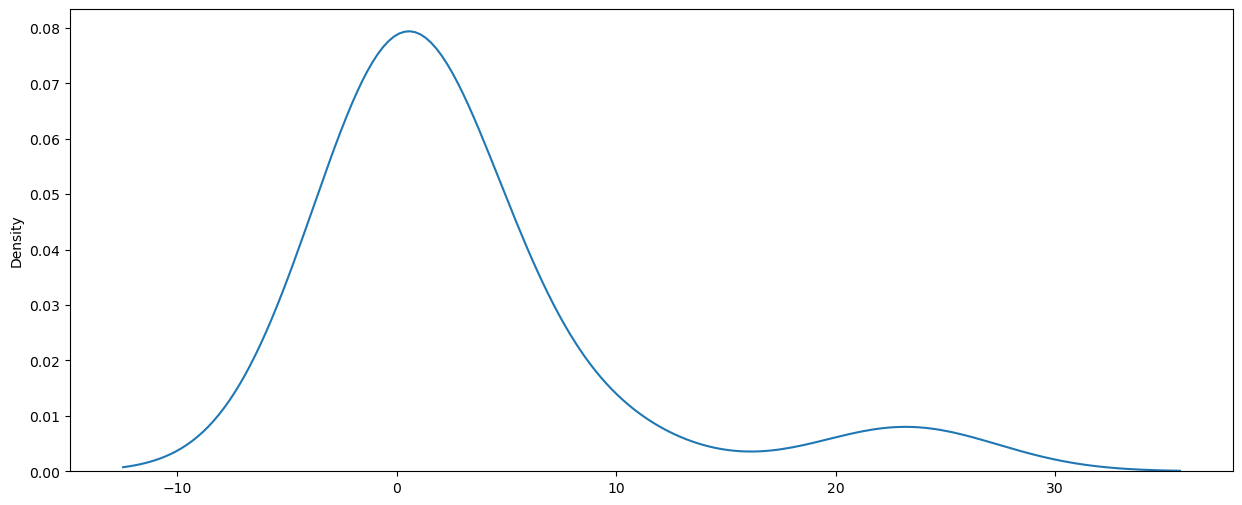

In [77]:
import seaborn as sns
from scipy.stats import ks_2samp
import numpy as np
for i in range(2002,2019):
    try:
        fig1,ax = plt.subplots(figsize = (15,6))
        sns.distplot(lagdf.groupby(lagdf.index.year)['lag2'].apply(list)[i],hist=False,ax=ax)

#         ax1=ax.twinx()
#         sns.distplot(lagdf.groupby(lagdf.index.year)['batch'].apply(list)[i],hist=False,ax=ax1)
        print(ks_2samp(lagdf.groupby(lagdf.index.year)['lag3'].apply(list)[i],lagdf.groupby(lagdf.index.year)['batch'].apply(list)[i]))
    except:
        print(i)


<AxesSubplot:>

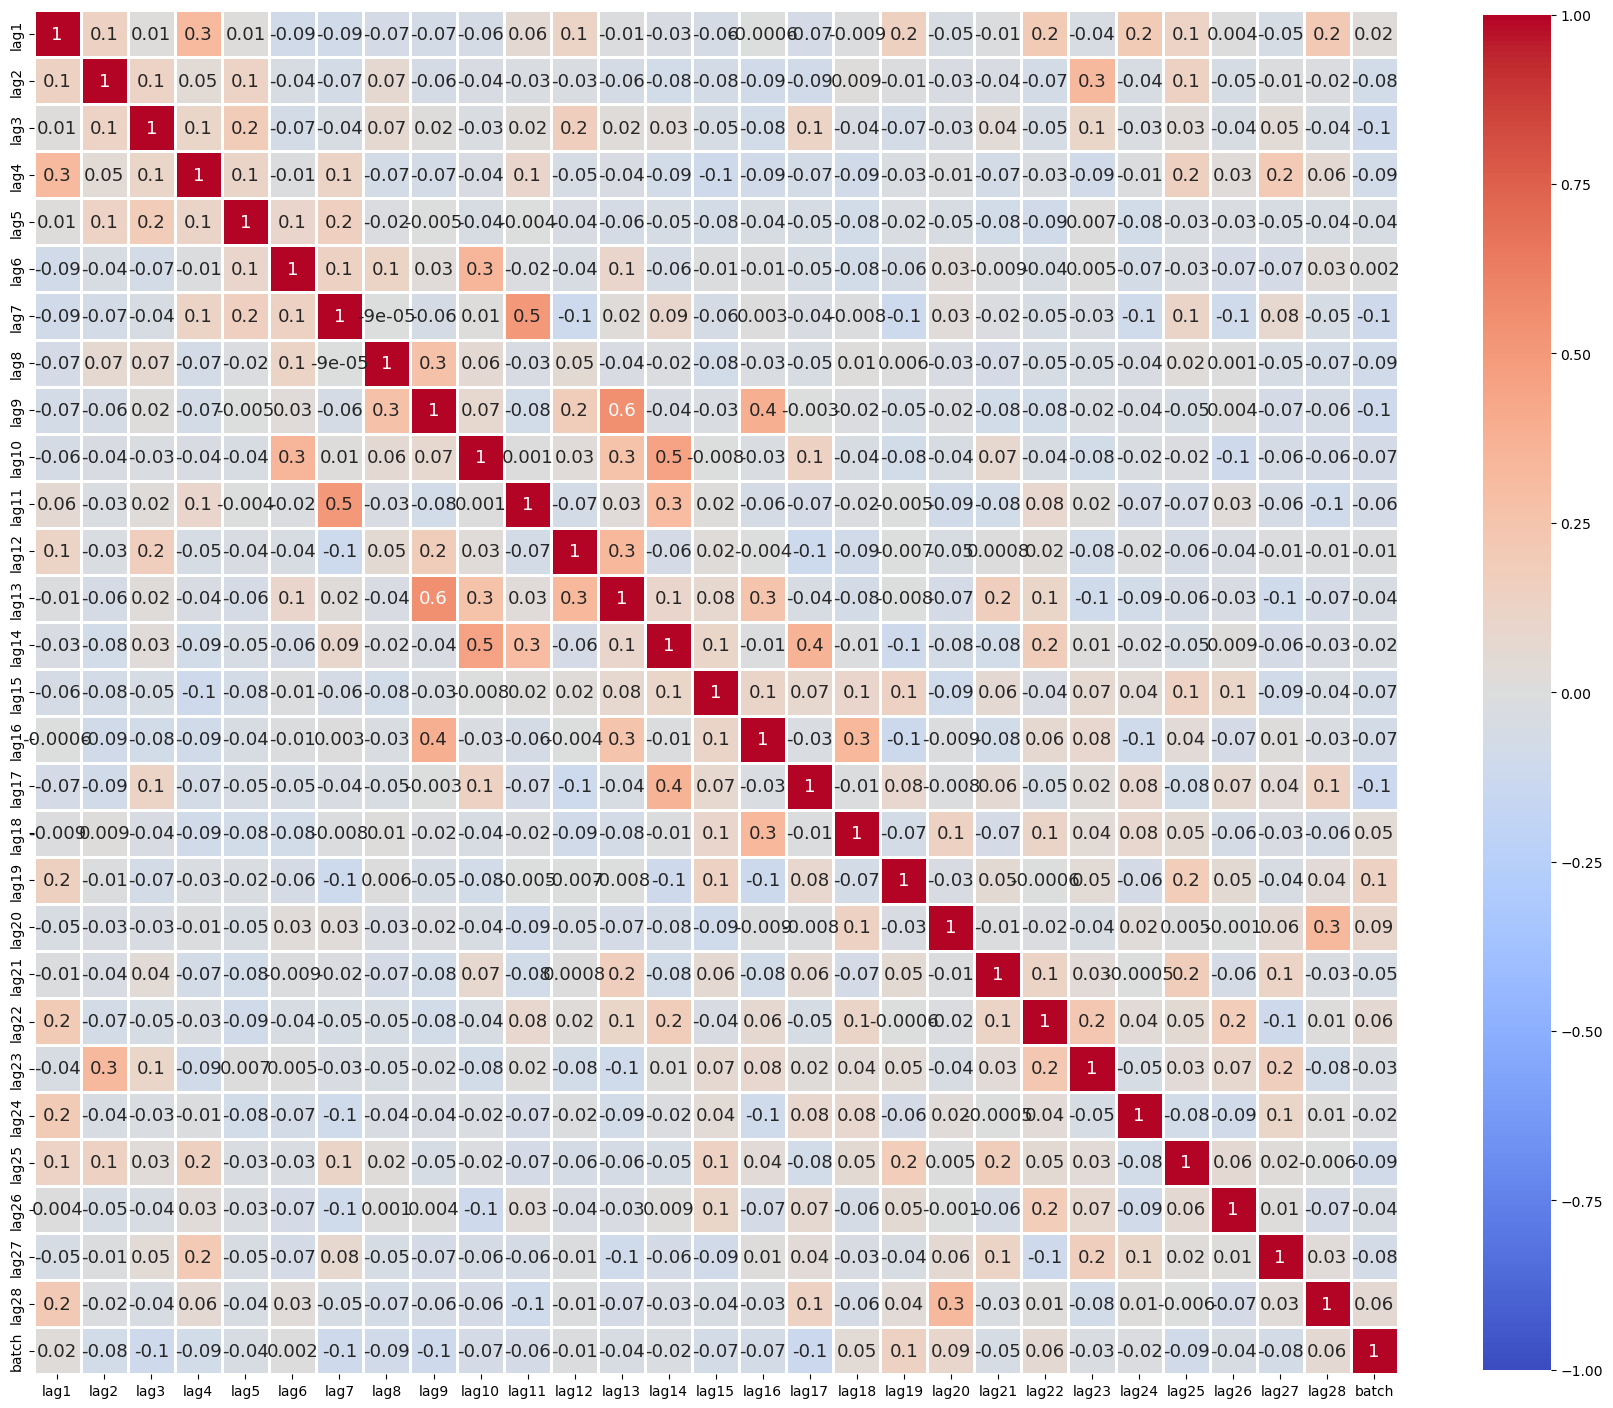

In [79]:
from matplotlib.pyplot import figure
figure(figsize=(22,22))
sns.heatmap(lagdf.corr(), cmap='coolwarm',vmin=-1, vmax=1,
                     square=True, linewidth=1,annot=True,annot_kws={'size':'13'},
                     cbar_kws={"shrink": 0.8}, fmt='.1g',center=0)

<AxesSubplot:>

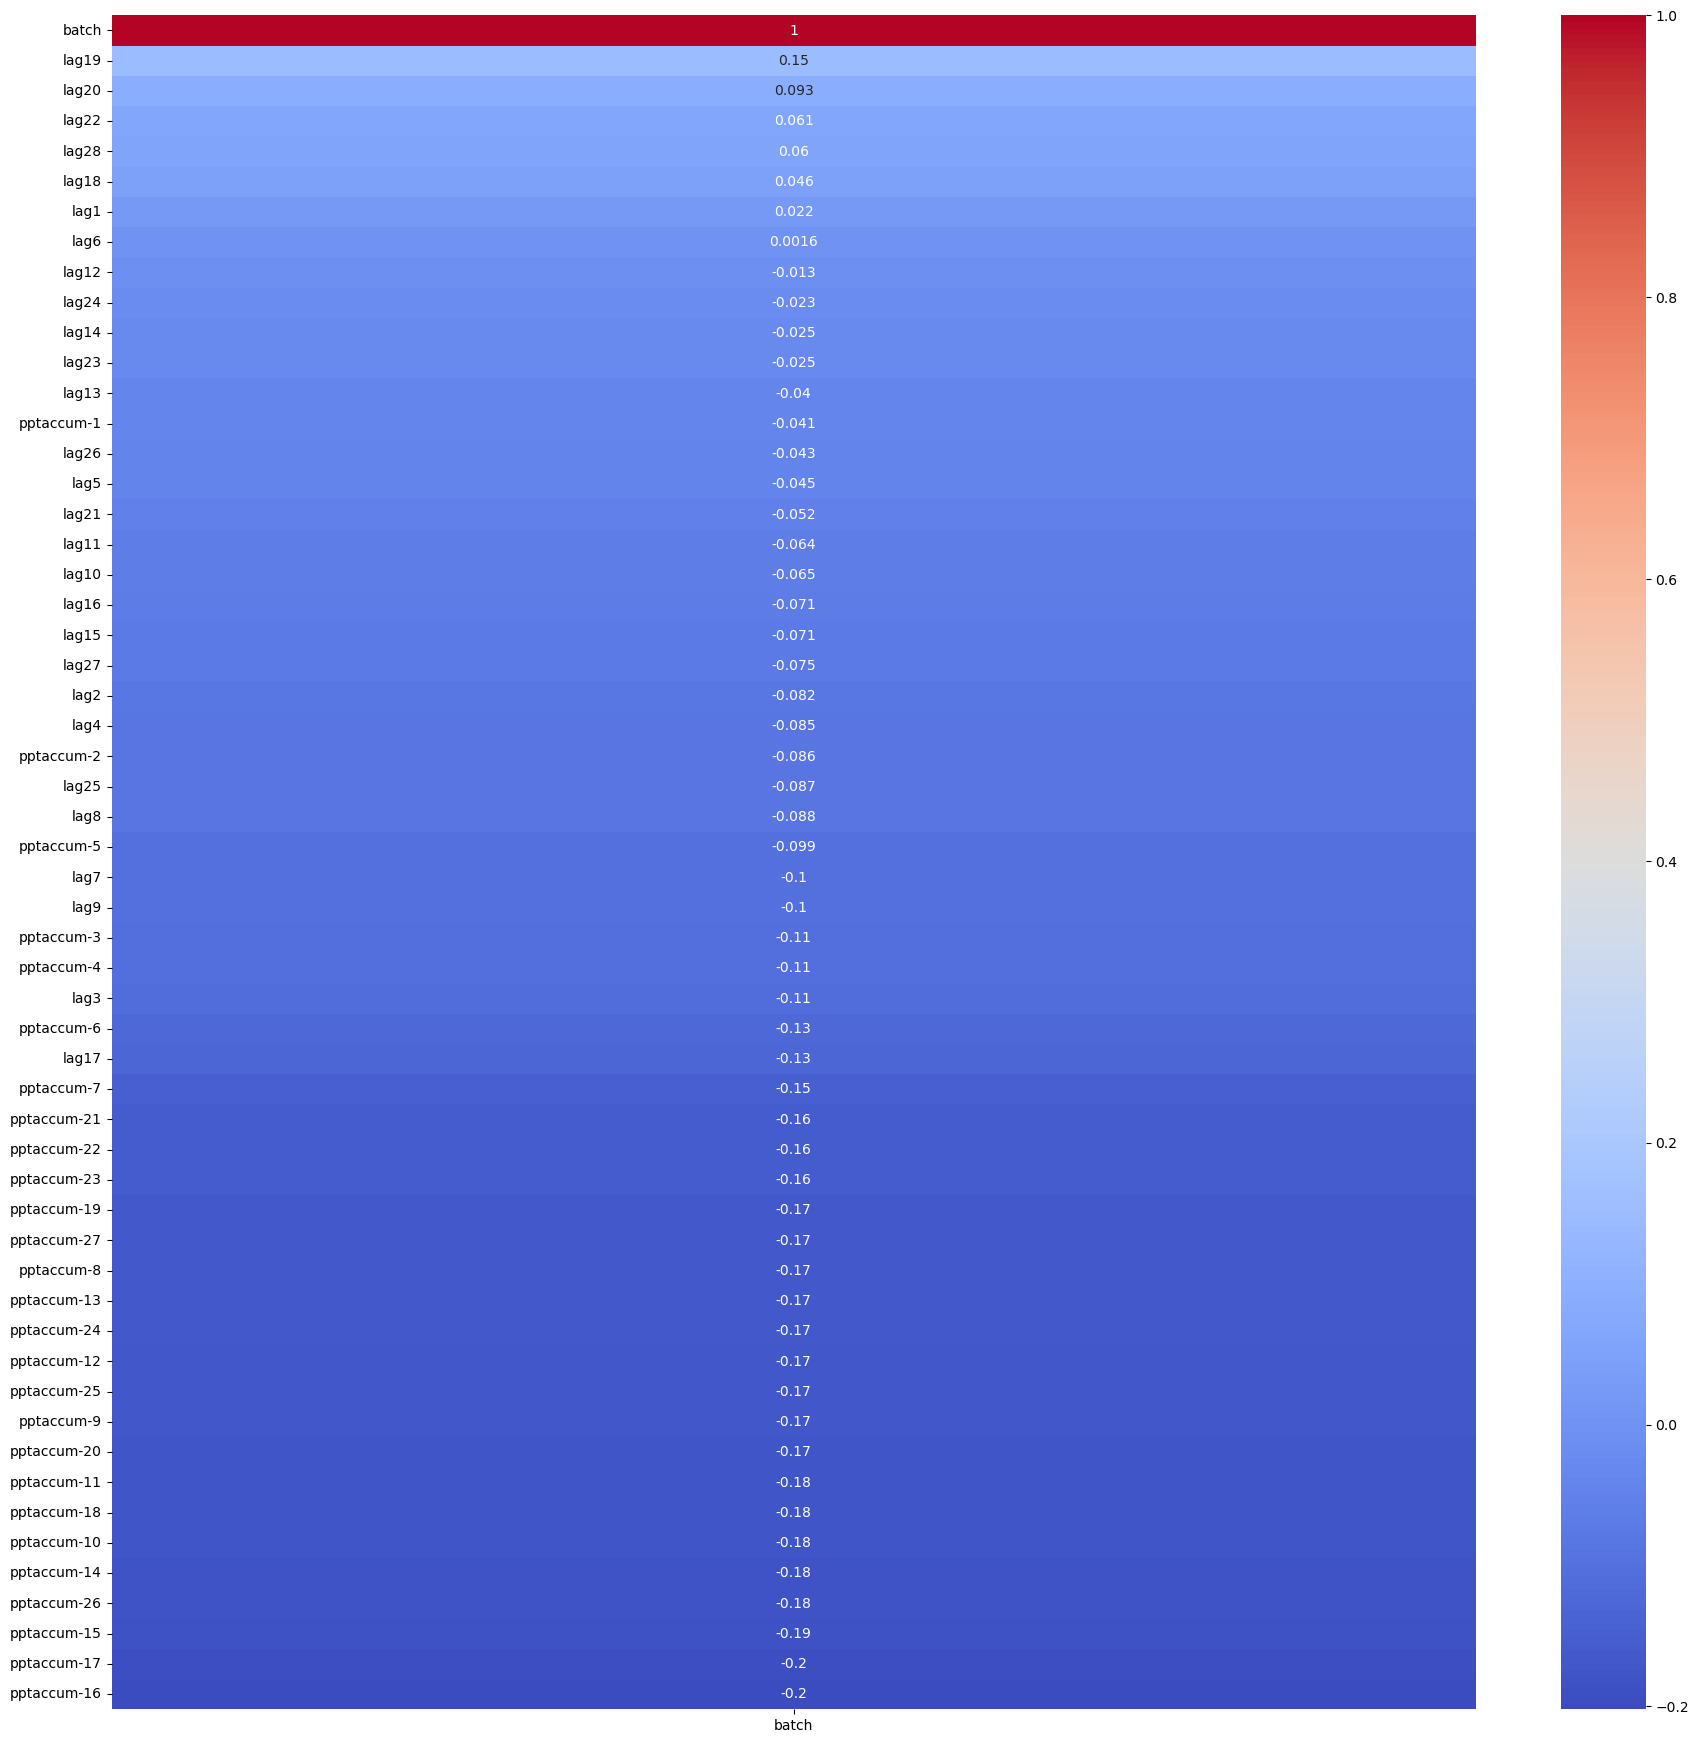

In [17]:
import seaborn as sns
corr = lagdf.corr()[['batch']].sort_values(ascending=False, by='batch')
plt.figure(figsize=(22,22))
sns.heatmap(corr, cmap='coolwarm', annot=True, vmax=1)

In [15]:
for i in range(2,len(lagdf.columns)):
    lagdf['pptaccum-'+str(i-1)] = lagdf[lagdf.columns[:i]].sum(axis=1)

<AxesSubplot:>

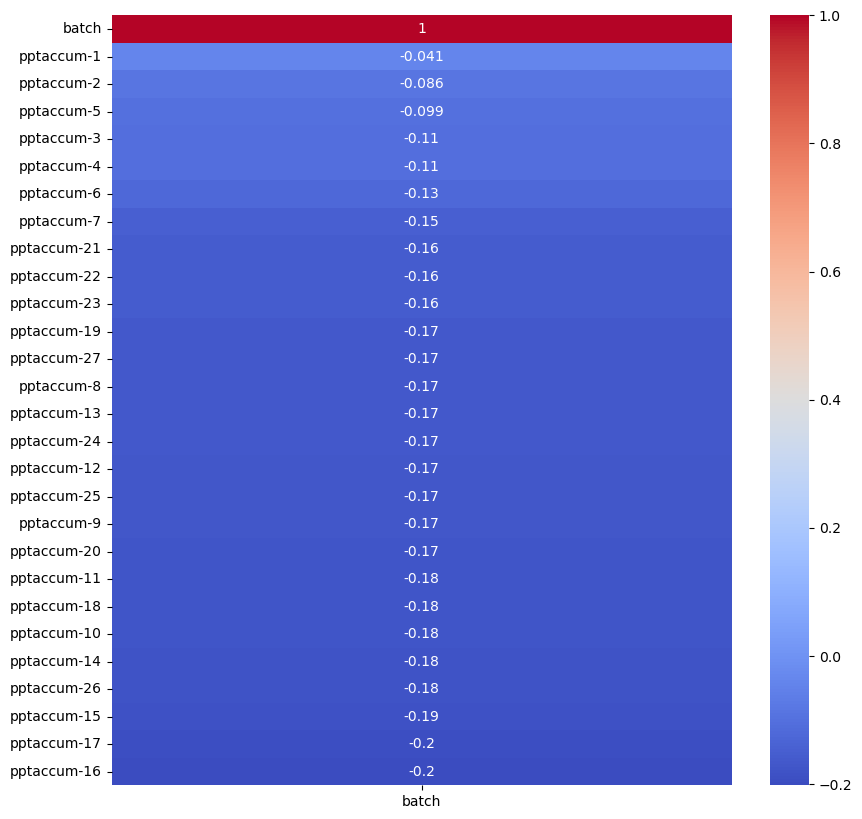

In [18]:
corr1 = lagdf[lagdf.columns[28:]].corr()[['batch']].sort_values(ascending=False, by='batch')
plt.figure(figsize=(10,10))
sns.heatmap(corr1, cmap='coolwarm', annot=True, vmax=1)

In [114]:
for i in range(2,28):    
    lagdf['pptweighted-'+str(i+1)] = sum(map(np.array,[lagdf[lagdf.columns[j]]*(i+1) for j in range(0,i)]))

<AxesSubplot:>

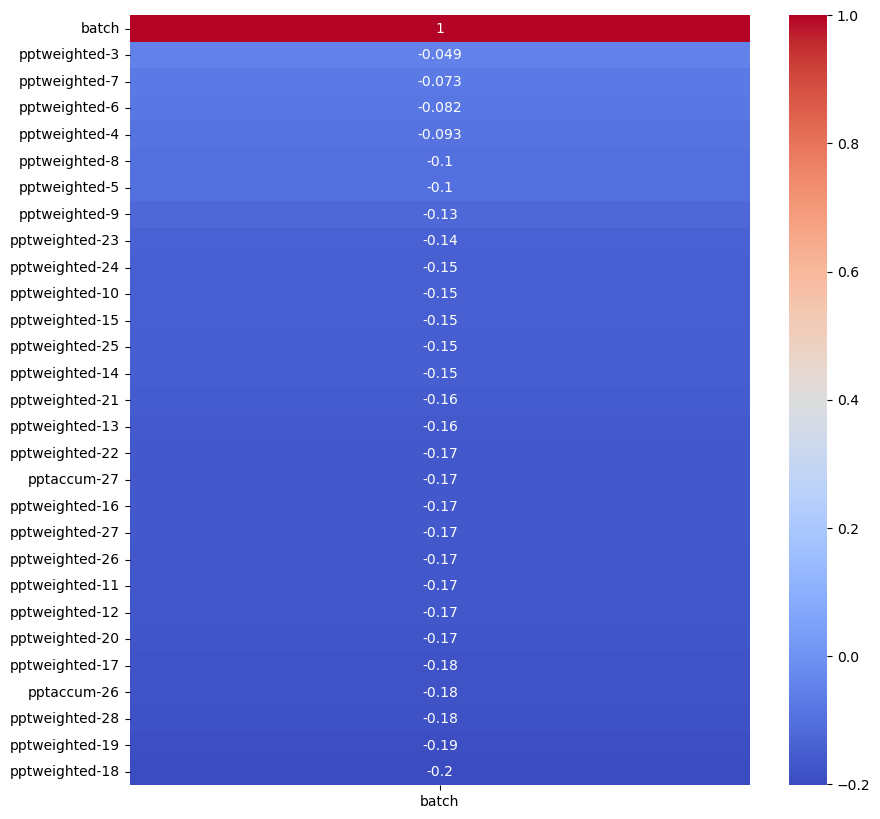

In [115]:

corr2 = lagdf[['batch',*lagdf.columns[-28:]]].corr()[['batch']].sort_values(ascending=False, by='batch')
plt.figure(figsize=(10,10))
sns.heatmap(corr2, cmap='coolwarm', annot=True, vmax=1)

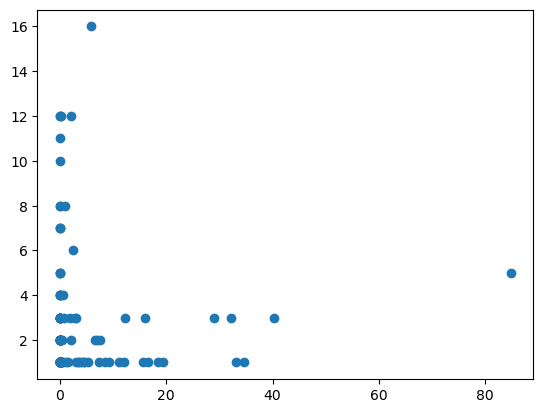

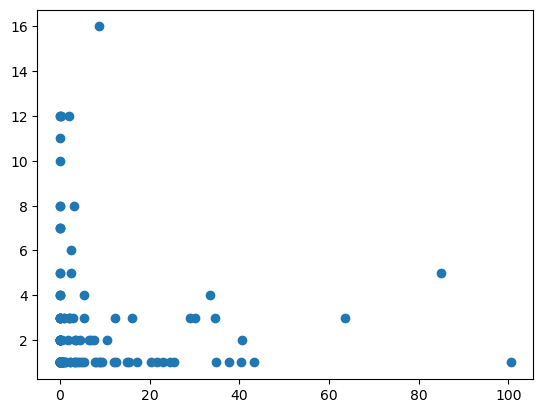

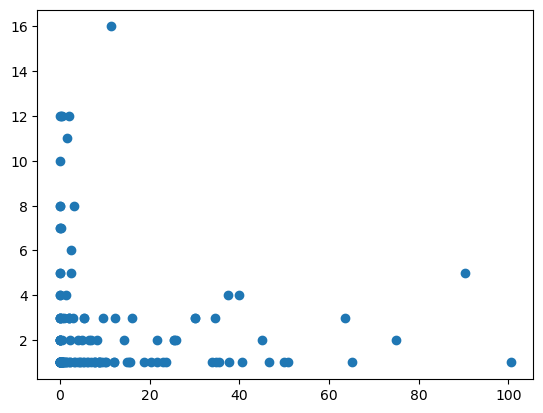

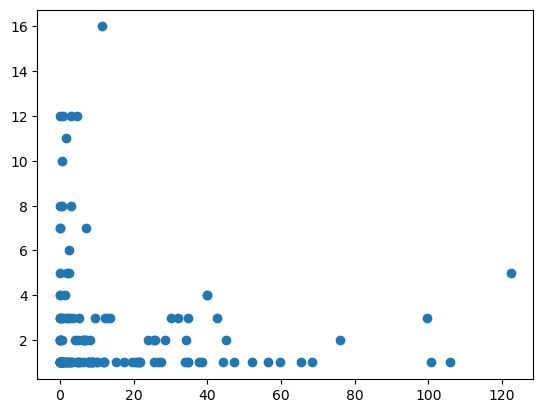

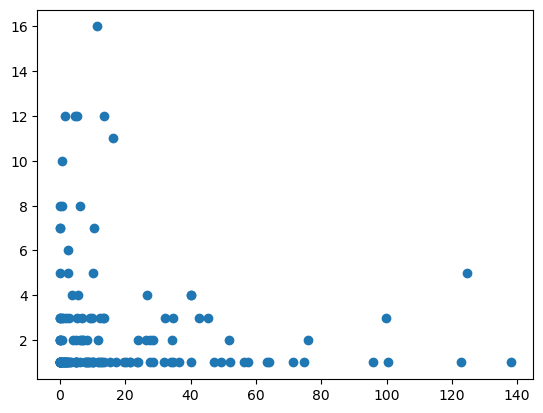

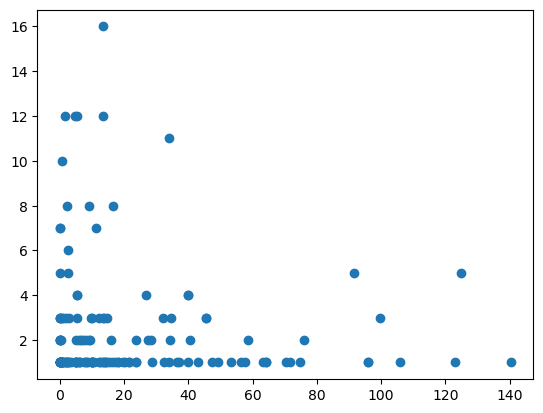

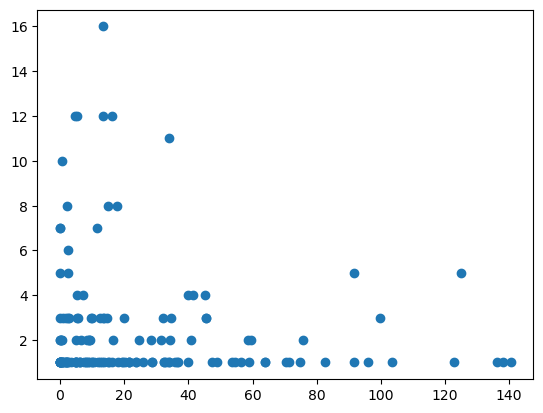

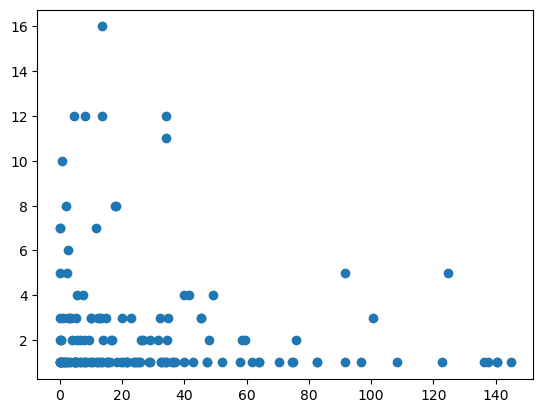

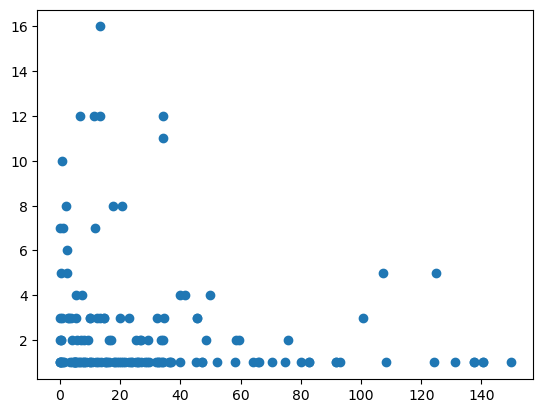

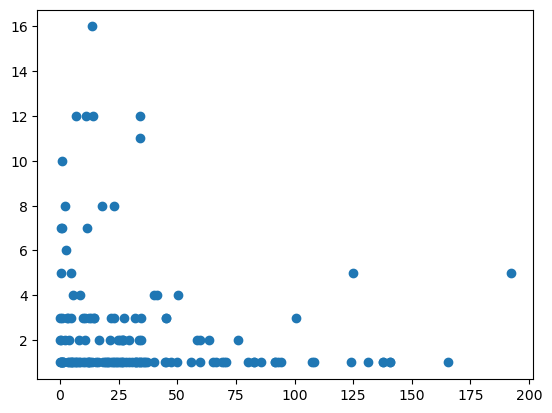

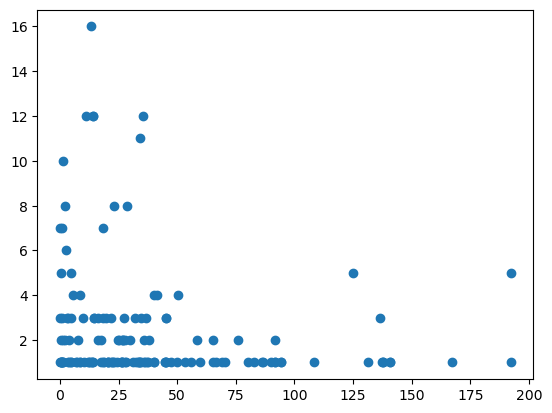

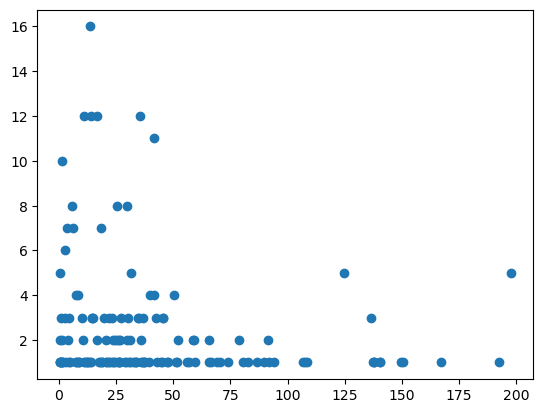

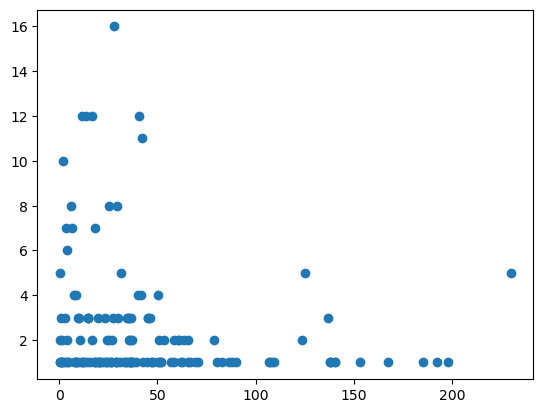

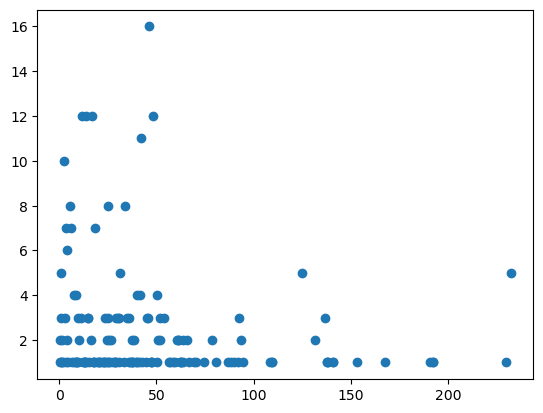

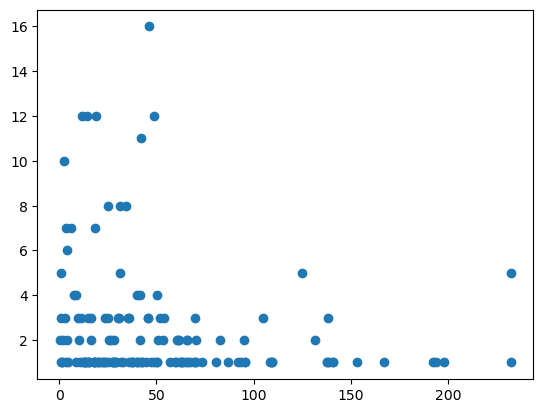

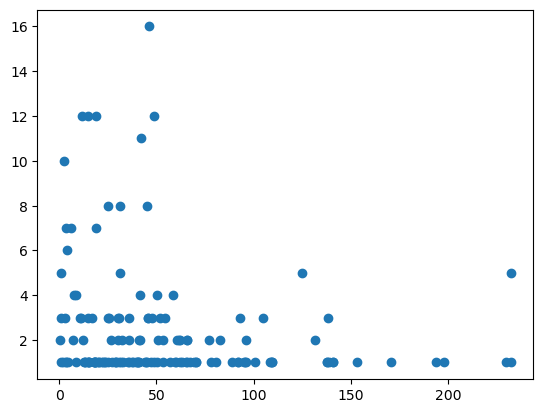

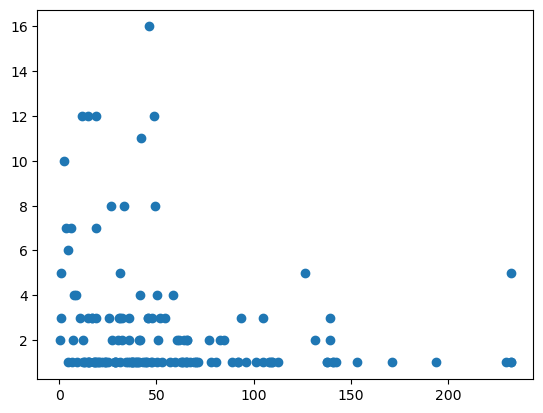

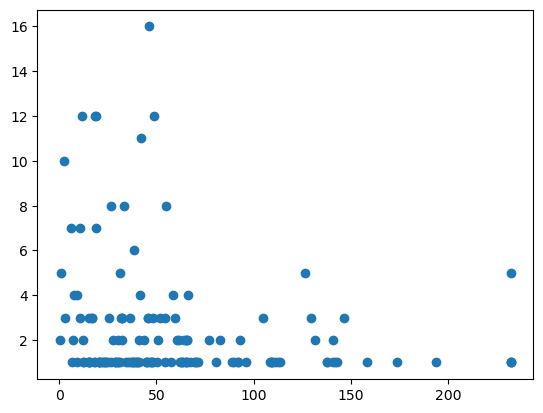

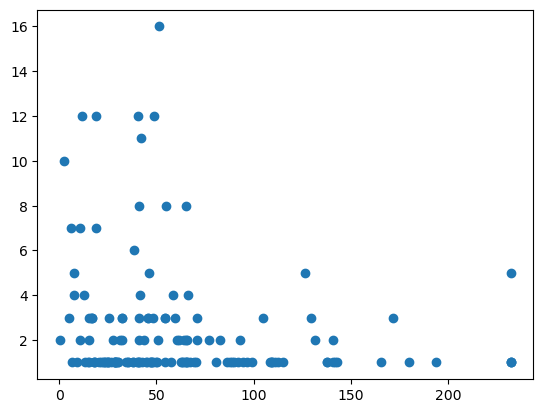

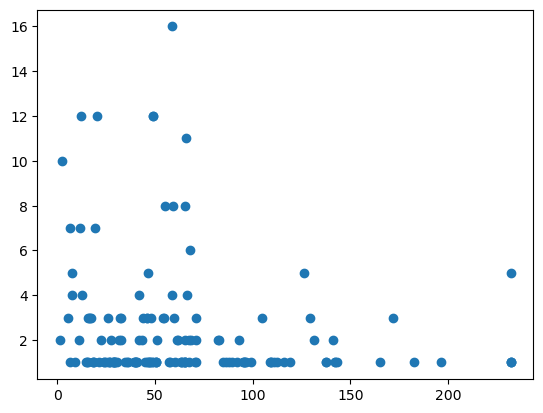

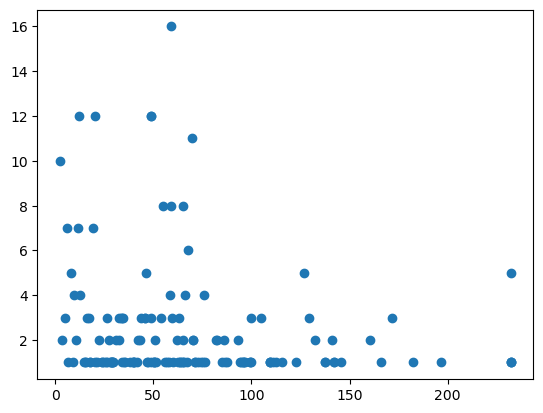

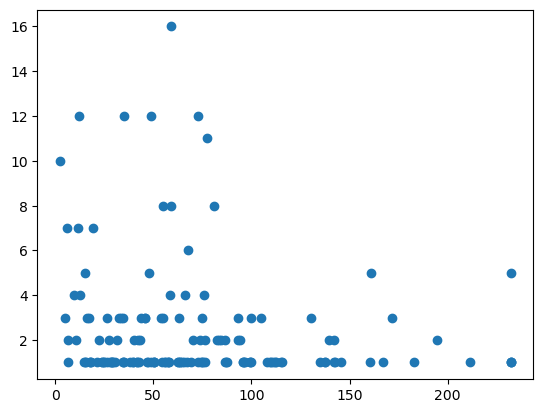

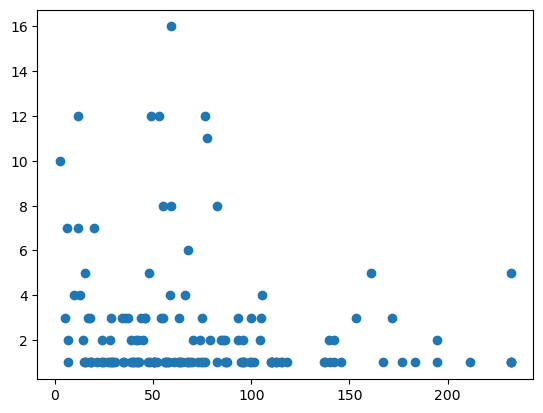

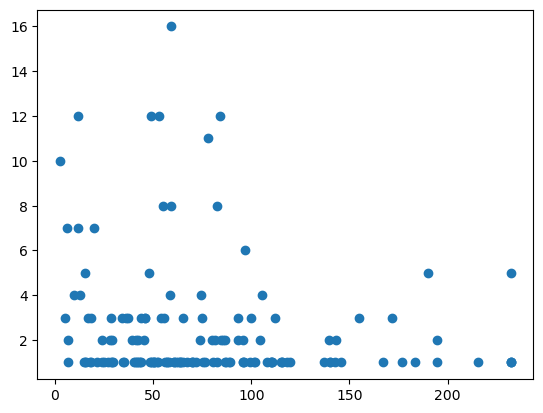

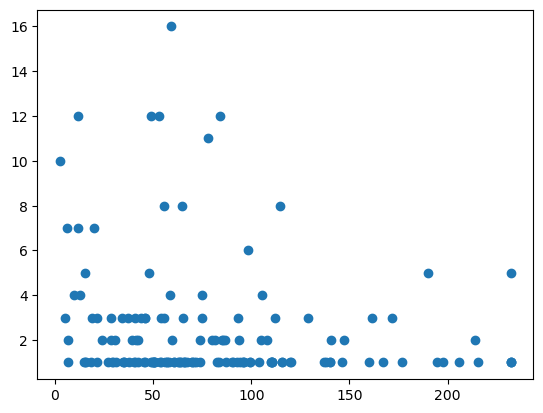

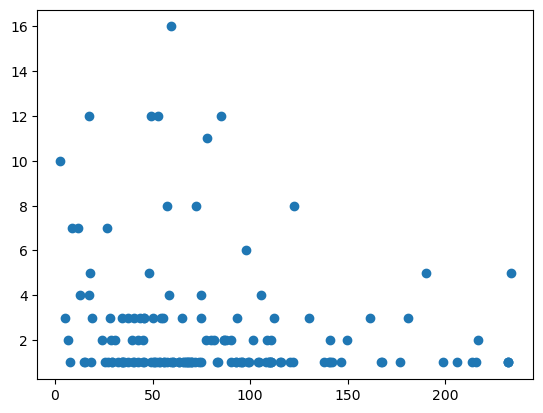

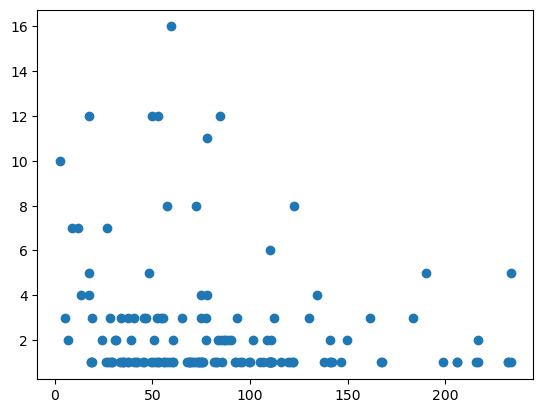

In [55]:
lagdf=lagdf.sort_values('batch')
for i in range(1,len(lagdf.columns)):
    plt.scatter(lagdf[lagdf.columns[:i]].sum(axis=1),lagdf.index)
    plt.show()

(array([3.888e+03, 2.860e+02, 9.900e+01, 6.500e+01, 2.300e+01, 1.000e+01,
        3.000e+00, 2.000e+00, 4.000e+00, 3.000e+00]),
 array([ 0.      ,  9.613333, 19.226665, 28.84    , 38.45333 , 48.066666,
        57.68    , 67.293335, 76.90666 , 86.52    , 96.13333 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

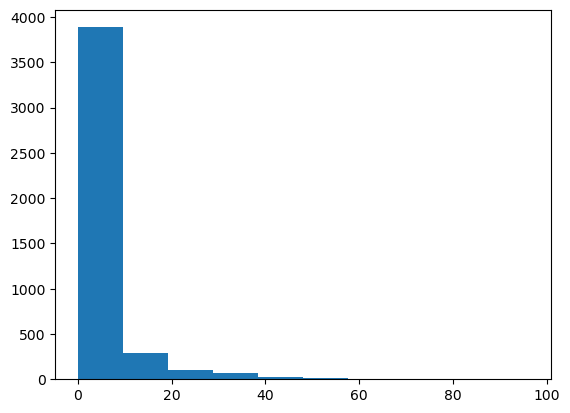

In [120]:
plt.hist(cutempo)